# [SF-DST] Car Price Prediction
# Прогнозирование стоимости автомобиля по характеристикам

## Загружаем библиотеки 

In [1]:
# pip install xgboost

In [2]:
# pip install catboost

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import statistics
import json
from itertools import combinations
from scipy.stats import ttest_ind
from pylab import rcParams

import matplotlib.pyplot as plt # для отрисовки графиков
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings("ignore")

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.5


In [5]:
RANDOM_SEED = 42

## Функции

In [6]:
# функция показывающая метрику
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Функция, которая  ищет пересечение уникальных значений признаков.
def intersection_stat(col1,col2):   
    col1_set = set(col1.astype(str).unique())
    col2_set = set(col2.astype(str).unique())
    intersection = col1_set.intersection(col2_set)
    print(len(col1_set),len(col2_set),len(intersection))

In [8]:
# Функция для отрисовки коробочной диаграммы для нечисловых признаков.
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=data[data['Sample'] == 1],
                ax=ax)
    plt.xticks(rotation=45)

    ax.set_ylim(0, (data.price.quantile(0.75) + 8 *
                    (data.price.quantile(0.75) - data.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column)
    plt.show()

In [9]:
# Функция выводит инфорамцию о границах выборосов для признака.
def iqr_analysis(series, mode=False):
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{f}, {l}].".format(
            f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < f:
        print("Найдены выбросы по нижней границе признака! Количество: {}, {}%".format(series.where(
            series < f).count(), round(series.where(series < f).count()/series.count()*100, 2)))
    if series.max() > l:
        print("Найдены выбросы по верхней границе признака! Количество: {}, {}%".format(series.where(
            series > l).count(), round(series.where(series > l).count()/series.count()*100, 2)))

In [10]:
# Функция поиска статистически значимых различий для колонки с помощью теста Стьюдента.
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))

    tmp = data[data['Sample'] == 1]

    for comb in combinations_all:
        if ttest_ind(tmp.loc[data[data['Sample'] == 1].loc[:, column] == comb[0], 'price'],
                     tmp.loc[data[data['Sample'] == 1].loc[:, column] == comb[1], 'price']).pvalue <= 0.05/len(combinations_all):  # учли поправку Бонферони
            pass
        else:
            print(
                'Не найдены статистически значимые различия для колонки и комбинации', column, comb)
            return column
            break

In [11]:
# функция, которая вынимает список available_options из complectation_dict
def get_available_options(x):
    s = str(x)
    if s =='nan':
        return []
    return json.loads(x)['available_options']

In [12]:
# функция переводит значения в строку, заполняем nan
def get_available_options_1(x):
    s = str(x)
    if s =='nan':
        return []
    return eval(x)

In [13]:
# функция, которая создает колонки с новыми признаками из топ 20
def create_features_for_top_20_options(df,options_list):
    for option in options_list:
        df['HAS_OPTION_'+ option] = df.complectation_dict.map(lambda x: int(option in x))

In [14]:
# функция, которая чистит данные из engineDisplacement и делает этот параметр числом float
def engineDisplacement_convertion(x):
    x = str(x).split(' ')[0]
    if x == 'nan':
        return np.nan
    if x =='':
        return np.nan
    return float(x)

In [15]:
# функция, которая чисти данные из enginePower и делает этот параметр целым числом
def enginePower_convertion(x):
    x = str(x).split(' ')[0]
    if x == 'nan' or x == 'undefined':
        return np.nan
    return int(x)

In [16]:
# Функция перевеодит формат данных "x лет y месяца(ев)" в количество месяцев.
def num_of_months(row):
    if pd.notnull(row) and row != 'no_data':
        list_ownership = row.split()  # разделяем строку на список из месяца и лет
        if len(list_ownership) == 2:  # если содержится информация только про годы
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])  # переводим год в месяцы
        return int(list_ownership[0])*12 + int(list_ownership[3])

# Парсинг

In [17]:
# import numpy as np
# import pandas as pd
# import requests
# from bs4 import BeautifulSoup
# import re
# import time
# import sys

# list_for_test = ['skoda','audi','honda','volvo','bmw',
#                  'nissan','infiniti','mercedes','toyota','lexus','volkswagen','mitsubishi']


# pagina = {}
# for brend in list_for_test:
#     url = f'https://auto.ru/moskva/cars/{brend}/used/'
#     res = requests.get(url)
#     soup = BeautifulSoup(res.content, 'html.parser')
#     pagina[brend] = soup.find_all('div', class_='ListingCarsPagination')[0].find_all('span', 'Button__text')


# for brend in list_for_test:
#     pagina[brend] = int(pagina[brend][-3].text)
    
# pagina 

# car_url = {key: [] for key in list_for_test} 
# start = time.time()
# for brend in sorted(list_for_test):
#     print(f'{brend}:')
#     for page in [1]:#range(1, pagina[brend] + 1):
        
#         url =f'https://auto.ru/moskva/cars/{brend}/used/?page={page}'    
#         time.sleep(0.001)
        
#         soup = BeautifulSoup(requests.get(url).content.decode('utf-8'), 'html.parser')
#         ref_lst = [ref['href'] for ref in soup.find_all('a', class_='Link ListingItemTitle__link')]
#         car_url[brend]+=ref_lst
#         sys.stdout.write(f'\r page = {page} (осталось {pagina[brend] - page})')
#         sys.stdout.flush()
#     print()
# delta = int(round(time.time() - start, 0))
# print(f'Длительность: {delta//60} мин. {delta%60} сек.')
# car_url
# len(car_url)

# full_data = []
# for brand in car_url:
#     for url in car_url[brand]:
# #         headers = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
# #         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36'}
#         time.sleep(0.001)
               
#         soup = BeautifulSoup(requests.get(url).content, 'lxml')
        
#         ids_list = soup.find_all('div', class_='CardHead__infoItem CardHead__id')  
#         if len(ids_list) == 0:
#             continue
#         car_id = ids_list[0].text[2:]
        
#         list1 = [ref.text for ref in soup.find_all('span', class_="CardInfoRow__cell")]
#         headers = list1[0::2]
#         values = list1[1::2]
#         car_data = dict(zip(headers,values))
#         for key in car_data:
#             car_data[key]=car_data[key].replace('\xa0',' ')
#         car_data['brend'] = brand
#         car_data['car_id'] = car_id
#         car_data['url'] = url
#         full_data.append(car_data)

# Data

In [18]:
train = pd.read_csv('train_df_full_part1.csv') 
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission (3).csv')

In [19]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [20]:
train.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"['cruise-control', 'multi-wheel', 'xenon', 'he...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,76.0,24 сентября,в Тюмени,999000.0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,259.0,24 сентября,в Санкт-Петербурге,1179000.0


In [21]:
# Посмотрим соответствие колонок в train и test 
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list)

Список колонок, которых нет в train, но есть в test: []
Список колонок, которых нет в test, но есть в train: ['date_added', 'region', 'views', 'price']


In [22]:
# так как в test этих колонок нет, то мы их удаляем, колонку price оставляем, так как это наш таргет
train = train.drop(['views','date_added','region'], axis = 1)

In [23]:
# посмотрим на целевую переменную
train.price.isnull().value_counts()

False    109765
True      20436
Name: price, dtype: int64

In [24]:
# Удаляем строки с price = NAN
train.dropna(subset=['price'], inplace=True)

In [25]:
train.shape

(109765, 33)

# EDA

Сравним типы данных в test и train, посмотрим расхождения и устраним их.

In [26]:
# Сгенерируем список с колонками, которые есть и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [27]:
# Теперь проверим где есть различия в типах данных
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Расхождения в типах данных для:
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки parsing_unixtime: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки productionDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки vendor: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки model_info: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки complectation_dict: для train - <class 'str'>, для test - <class 'float'>
	- колонки mileage: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки sell_id: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>


In [28]:
# Приводим данные в колонках к одному типу, в тех колонках, в которых это возможно

train.numberOfDoors = train.numberOfDoors.astype('Int64')
train.modelDate = train.modelDate.astype('Int64')
train.productionDate = train.productionDate.astype('Int64')
train.sell_id = train.sell_id.astype('Int64')
test.mileage = test.mileage.astype('float') 
train.parsing_unixtime = train.parsing_unixtime.astype('Int64')
train.vendor = train.vendor.astype('str')
train.model_info = train.model_info.astype('str')
test.complectation_dict = test.complectation_dict.astype('str')

## car_url, parsing_unixtime

In [29]:
test.car_url.value_counts()

https://auto.ru/cars/used/sale/toyota/celica/1088313932-1b2651ad/        1
https://auto.ru/cars/used/sale/toyota/camry/1101140175-7f5a0ca9/         1
https://auto.ru/cars/used/sale/skoda/octavia/1091517892-18aecd36/        1
https://auto.ru/cars/used/sale/volkswagen/passat/1100790180-9bf7cf66/    1
https://auto.ru/cars/used/sale/nissan/almera/1101259175-8da9496d/        1
                                                                        ..
https://auto.ru/cars/used/sale/audi/q3/1098863418-64d6f627/              1
https://auto.ru/cars/used/sale/audi/q7/1100878718-b84b0ee5/              1
https://auto.ru/cars/used/sale/bmw/7er/1100985396-337c9047/              1
https://auto.ru/cars/used/sale/skoda/octavia/1101159635-06f510d2/        1
https://auto.ru/cars/used/sale/nissan/x_trail/1101074446-15240975/       1
Name: car_url, Length: 34686, dtype: int64

In [30]:
train.car_url.value_counts()

https://auto.ru/cars/new/group/toyota/rav_4/21678504/22537343/1104963137-e0e9d5dc/                 428
https://auto.ru/cars/new/group/toyota/land_cruiser_prado/22495145/22496061/1104717062-6ae14d83/    428
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105222495-22d7ca53/                            427
https://auto.ru/cars/new/group/toyota/camry/22813335/22813675/1103971886-d3b55172/                 427
https://auto.ru/cars/new/group/toyota/land_cruiser/22905534/22947809/1104844023-ce267fd2/          426
                                                                                                  ... 
https://auto.ru/cars/used/sale/infiniti/fx/1103400362-d9cf7565/                                      1
https://auto.ru/cars/used/sale/volkswagen/jetta/1105049692-7166b484/                                 1
https://auto.ru/cars/used/sale/toyota/hilux/1105174051-622299ab/                                     1
https://auto.ru/cars/used/sale/mercedes/cls_klasse/1104921492-99f348ed/  

мы видим, что на некоторые ссылки есть больше, чем 1 строка, поэтому попробуем удалить дубликаты

In [31]:
train.shape

(109765, 33)

In [32]:
train.drop_duplicates().shape

(109765, 33)

это не особо помогло, поэтому посмотрим количество уникальных значений для одной из ссылок

In [33]:
# смотрим количество уникальных значений для одной из ссылок
tmp = train[train.car_url == 'https://auto.ru/cars/new/group/toyota/land_cruiser_prado/22495145/22496061/1104717062-6ae14d83/']
for col in tmp.columns:
    print(col,tmp[col].nunique())

bodyType 1
brand 1
car_url 1
color 1
complectation_dict 1
description 2
engineDisplacement 1
enginePower 1
equipment_dict 4
fuelType 1
image 4
mileage 0
modelDate 1
model_info 1
model_name 0
name 1
numberOfDoors 1
parsing_unixtime 428
priceCurrency 1
productionDate 1
sell_id 1
super_gen 6
vehicleConfiguration 1
vehicleTransmission 1
vendor 1
Владельцы 0
Владение 0
ПТС 0
Привод 0
Руль 0
Состояние 0
Таможня 0
price 2


Видим, что parsing_unixtime имеет много уникальных значений на одну и ту же ссылку 

In [34]:
train.complectation_dict = train.complectation_dict.astype(str)

In [35]:
tmp.parsing_unixtime.diff().describe()

count      427.000000
mean       130.990632
std        624.991568
min         53.000000
25%         89.000000
50%        101.000000
75%        106.000000
max      13008.000000
Name: parsing_unixtime, dtype: float64

In [36]:
# сортируем значения parsing_unixtime, группируем их с car_url и берем самое последнее значение parsing_unixtime
train = train.sort_values('parsing_unixtime').groupby('car_url').tail(1).reset_index(drop=True)

проверяем, видим, что теперь каждому элементу соответствует одна ссылка

In [37]:
test.car_url.value_counts()

https://auto.ru/cars/used/sale/toyota/celica/1088313932-1b2651ad/        1
https://auto.ru/cars/used/sale/toyota/camry/1101140175-7f5a0ca9/         1
https://auto.ru/cars/used/sale/skoda/octavia/1091517892-18aecd36/        1
https://auto.ru/cars/used/sale/volkswagen/passat/1100790180-9bf7cf66/    1
https://auto.ru/cars/used/sale/nissan/almera/1101259175-8da9496d/        1
                                                                        ..
https://auto.ru/cars/used/sale/audi/q3/1098863418-64d6f627/              1
https://auto.ru/cars/used/sale/audi/q7/1100878718-b84b0ee5/              1
https://auto.ru/cars/used/sale/bmw/7er/1100985396-337c9047/              1
https://auto.ru/cars/used/sale/skoda/octavia/1101159635-06f510d2/        1
https://auto.ru/cars/used/sale/nissan/x_trail/1101074446-15240975/       1
Name: car_url, Length: 34686, dtype: int64

In [38]:
train.car_url.value_counts()

https://auto.ru/cars/used/sale/mercedes/m_klasse/1105172690-dcfd17eb/                 1
https://auto.ru/cars/used/sale/lexus/lx/1105187178-e19d0901/                          1
https://auto.ru/cars/used/sale/infiniti/ex/1105347071-a58c3ec4/                       1
https://auto.ru/cars/used/sale/infiniti/qx60/1104945579-9bb61070/                     1
https://auto.ru/cars/used/sale/mercedes/glk_klasse/1105399364-fb3cd502/               1
                                                                                     ..
https://auto.ru/cars/used/sale/audi/q5/1105227688-712f7cac/                           1
https://auto.ru/cars/used/sale/nissan/leaf/1105394508-6c9206bf/                       1
https://auto.ru/cars/used/sale/skoda/yeti/1105281649-8dc50f7f/                        1
https://auto.ru/cars/used/sale/skoda/octavia/1105372507-f299079b/                     1
https://auto.ru/cars/new/group/toyota/rav_4/21678468/21678562/1105119702-75f5f1a5/    1
Name: car_url, Length: 36586, dt

## complectation_dict

Посмотрим что из себя представляют данные в test и в train

In [39]:
train.complectation_dict.value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [40]:
test.complectation_dict.value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Видим, что в test это словарь, а в train - список. Вынем словарь available_options из test и на основе полученных данных создадим новые признаки

In [41]:
# используем функцию, которая вынимает список available_options из complectation_dict
test.complectation_dict = test.complectation_dict.map(get_available_options)

In [42]:
# смотрим пересечения в train и test по complectation_dict
intersection_stat(train.complectation_dict,test.complectation_dict)  

2295 1500 225


In [43]:
# смотрим нулевые значения
test.complectation_dict.isnull().sum()

0

In [44]:
# используем функцию get_available_options_1 переводим значения в строку, заполняем nan  
train.complectation_dict = train.complectation_dict.map(get_available_options_1)

In [45]:
# сортируем значения в complectation_dict в train 
train.complectation_dict = train.complectation_dict.map(sorted)

In [46]:
# сортируем значения в complectation_dict в test
test.complectation_dict = test.complectation_dict.map(sorted)

In [47]:
# смотрим снова пересечения в train и test по complectation_dict
intersection_stat(train.complectation_dict,test.complectation_dict)  

2295 1500 226


In [48]:
test.complectation_dict[2]

['12v-socket',
 '16-inch-wheels',
 'abs',
 'adaptive-light',
 'airbag-driver',
 'airbag-passenger',
 'airbag-side',
 'ashtray-and-cigarette-lighter',
 'audiopreparation',
 'audiosystem-cd',
 'aux',
 'body-mouldings',
 'climate-control-1',
 'computer',
 'condition',
 'cooling-box',
 'door-sill-panel',
 'electro-mirrors',
 'electro-window-back',
 'electro-window-front',
 'esp',
 'fabric-seats',
 'front-centre-armrest',
 'front-seats-heat',
 'hcc',
 'heated-wash-system',
 'immo',
 'isofix',
 'light-sensor',
 'lock',
 'mirrors-heat',
 'ptf',
 'rain-sensor',
 'seat-transformation',
 'third-rear-headrest',
 'tyre-pressure',
 'wheel-configuration1',
 'wheel-configuration2',
 'wheel-leather',
 'wheel-power']

In [49]:
# создаем список топ 20-ти опций для создания новых признаков
complectation_list = list(train.complectation_dict.values)+list(test.complectation_dict.values)
car_options = []
for options in complectation_list:
    car_options += options
top_20_options = pd.Series(car_options).value_counts().head(20).index.values 

In [50]:
# используем функцию, которая создает колонки с новыми признаками из топ 20
create_features_for_top_20_options(train,top_20_options)
create_features_for_top_20_options(test,top_20_options)

In [51]:
train.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,HAS_OPTION_wheel-configuration2,HAS_OPTION_electro-window-back,HAS_OPTION_esp,HAS_OPTION_front-seats-heat,HAS_OPTION_airbag-side,HAS_OPTION_isofix,HAS_OPTION_seat-transformation,HAS_OPTION_audiopreparation,HAS_OPTION_audiosystem-cd,HAS_OPTION_wheel-leather
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"[12v-socket, 17-inch-wheels, abs, adaptive-lig...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,1,1,1,1,1,1,1,1,1,1
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"[12v-socket, 15-inch-wheels, abs, airbag-curta...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,1,0,1,1,1,1,0,0,1,1


## engineDisplacement

In [52]:
train.engineDisplacement.value_counts()

2.0 LTR    11128
1.6 LTR     4657
3.0 LTR     3486
2.5 LTR     2221
1.4 LTR     2086
2.4 LTR     2012
3.5 LTR     1819
1.8 LTR     1800
1.5 LTR     1077
1.3 LTR      472
1.2 LTR      467
4.0 LTR      428
2.9 LTR      362
5.7 LTR      357
4.5 LTR      350
2.8 LTR      321
5.6 LTR      276
3.7 LTR      271
2.7 LTR      270
4.7 LTR      256
4.4 LTR      247
4.6 LTR      243
2.1 LTR      228
2.3 LTR      199
3.2 LTR      187
5.5 LTR      186
2.2 LTR      142
0.7 LTR      135
3.6 LTR      123
5.0 LTR       92
4.2 LTR       88
1.7 LTR       88
1.9 LTR       83
3.3 LTR       79
 LTR          77
4.3 LTR       40
3.1 LTR       33
3.8 LTR       33
1.0 LTR       32
3.4 LTR       32
2.6 LTR       19
6.0 LTR       15
5.4 LTR       12
6.2 LTR       11
4.8 LTR       11
4.1 LTR        9
6.6 LTR        8
5.2 LTR        7
5.9 LTR        6
1.1 LTR        2
4.9 LTR        2
5.8 LTR        1
Name: engineDisplacement, dtype: int64

In [53]:
test.engineDisplacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.9 LTR      12
5.2 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [54]:
# используем функцию, которая чистит данные из engineDisplacement и делает этот параметр числом float
test.engineDisplacement = test.engineDisplacement.map(engineDisplacement_convertion)
train.engineDisplacement = train.engineDisplacement.map(engineDisplacement_convertion)

In [55]:
test.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, nan, 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7])

In [56]:
train.engineDisplacement.unique()

array([1.8, 1.6, 1.2, 2. , 1.4, 3.6, 1.5, 1.9, 1.3, 2.8, 3. , 2.7, 4. ,
       2.4, 2.9, 4.2, 2.5, 3.2, 4.1, 3.1, 2.3, 2.2, 2.6, nan, 5.9, 5.2,
       3.7, 5. , 2.1, 6. , 3.5, 0.7, 1.7, 4.4, 4.8, 6.6, 4.6, 4.9, 3.4,
       5.4, 5.6, 1. , 3.3, 3.8, 4.5, 5.5, 4.7, 6.2, 5.8, 5.7, 4.3, 1.1])

In [57]:
statistics.mode(train.engineDisplacement)

2.0

## enginePower

In [58]:
train.enginePower.value_counts()
train.enginePower.unique()

array(['180 N12', '110 N12', '152 N12', '105 N12', '90 N12', '70 N12',
       '150 N12', '80 N12', '102 N12', '122 N12', '140 N12', '125 N12',
       '86 N12', '75 N12', '68 N12', '115 N12', '260 N12', '280 N12',
       '64 N12', '220 N12', '143 N12', '100 N12', '58 N12', '200 N12',
       '60 N12', '160 N12', '170 N12', '120 N12', '54 N12', '190 N12',
       '69 N12', '79 N12', '101 N12', '193 N12', '184 N12', '53 N12',
       '249 N12', '225 N12', '204 N12', '340 N12', '333 N12', '211 N12',
       '245 N12', '300 N12', '460 N12', '239 N12', '310 N12', '520 N12',
       '165 N12', '422 N12', '450 N12', '350 N12', '230 N12', '163 N12',
       '177 N12', '238 N12', '265 N12', '290 N12', '435 N12', '344 N12',
       '255 N12', '130 N12', '372 N12', '133 N12', '136 N12', '250 N12',
       '270 N12', '272 N12', '252 N12', '600 N12', '605 N12', '367 N12',
       '420 N12', '354 N12', '408 N12', '88 N12', '71 N12', '500 N12',
       '271 N12', '400 N12', '218 N12', '210 N12', '335 N12', '571

In [59]:
test.enginePower.value_counts()
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [60]:
# используем функцию, которая чисти данные из enginePower и делает этот параметр целым числом
test.enginePower = test.enginePower.map(enginePower_convertion)
train.enginePower = train.enginePower.map(enginePower_convertion)

## model_name

In [61]:
train.model_name.value_counts()

Octavia            1149
RX                  894
Outlander           709
Polo                675
CR-V                595
                   ... 
Town Box              1
Succeed               1
Sprinter Marino       1
Corolla Verso         1
Cavalier              1
Name: model_name, Length: 504, dtype: int64

In [62]:
test.model_name.value_counts()

OCTAVIA       1418
5ER           1026
LANCER         855
E_KLASSE       809
PASSAT         782
              ... 
100NX            1
100_SERIES       1
HS               1
PROGRES          1
280ZX            1
Name: model_name, Length: 544, dtype: int64

In [63]:
# смотрим пересечение значений
intersection_stat(train.model_name,test.model_name)

505 544 110


In [64]:
# при смене регистра пересечений становится больше
intersection_stat(train.model_name.str.upper(),test.model_name)

504 544 306


In [65]:
# меняем регистр названий в train на заглавные буквы
train.model_name = train.model_name.str.upper()

## name

In [66]:
test.name.value_counts()

1.6 AT (110 л.с.)                631
1.6 MT (102 л.с.)                410
1.6 MT (110 л.с.)                314
2.0 CVT (141 л.с.) 4WD           309
1.4 AMT (122 л.с.)               308
                                ... 
T-5R 2.3 AT (240 л.с.)             1
Fielder 1.5 AT (110 л.с.) 4WD      1
2.0d MT (83 л.с.)                  1
Runx 1.5 AT (110 л.с.) 4WD         1
5.0 MT (507 л.с.)                  1
Name: name, Length: 2780, dtype: int64

In [67]:
train.name.value_counts()

Skoda Rapid II                                               597
Volvo XC60 II                                                576
Mitsubishi Outlander III Рестайлинг 3                        475
Volkswagen Polo V Рестайлинг                                 404
Nissan Qashqai II Рестайлинг                                 394
                                                            ... 
BMW 7 серии Long 730Li IV (E65/E66) Рестайлинг                 1
Toyota Corolla Fielder X (E140, E150) Рестайлинг               1
Toyota 4Runner II                                              1
Mercedes-Benz S-Класс 600 Long VI (W222, C217) Рестайлинг      1
Volvo S60 Bi-Fuel I Рестайлинг                                 1
Name: name, Length: 2171, dtype: int64

In [68]:
# помотрим пересечение это признака в обоих датасетах
intersection_stat(train.name,test.name)

2171 2780 0


Видим, что пересечения у этих признаков нет, поэтому потом удалим его.

## sell_id 

Признак sell_id удалим, потом он нам будет нужен при сабмишене предсказания лучшей модели

In [69]:
train.sell_id[0]

1105110722

In [70]:
test.sell_id[0]

1100575026

## super_gen

Прийдется удалить, так как он использовался для генерирования других признаков

In [71]:
train.super_gen[0]

"{'sale-data-attributes': {'asciiCat': 'cars', 'category': 'cars', 'engine-type': 'GASOLINE', 'image': 'https://autoru.naydex.net/emUm14254/624f74NbAbbL/Aefzu5ZyCH7-o5Us79AXm7oeNB9uz7EWZFCtevIiZoG_rTRR4THa_racYfdbmbRzM5XVSQW_VSXiE5kmqnXC-lFGch7Cd3wbisKx-SqURk9qWiFKGk5Qc6ARXvlRdKSzHB7n4sdyWh7TKcAzT59isrcwk5z3G_XwdbVKsXojtolUoodp9pJ5TWzCYU1O8bBoOU-E378rIOYnVW_4gxSlggw-1TOG8fmuk3tEQL38E5ZXc0ONt8pHcEcl25LqYbZYc', 'km-age': 162026, 'mark': 'SKODA', 'markName': 'Skoda', 'model': 'OCTAVIA', 'modelName': 'Octavia', 'power': 180, 'price': 999000, 'puid2': '3189', 'puid10': '1', 'routeCategory': 'cars', 'segment': 'MEDIUM', 'state': 'used', 'transmission': 'ROBOT', 'type': '', 'year': 2015}}"

In [72]:
test.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

## vehicleConfiguration

Для тех категорий, у кого встречаемость на уровне 1 - можно позже обратить в OTHERS

In [73]:
train['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 2.0    3373
ALLROAD_5_DOORS VARIATOR 2.0     2765
ALLROAD_5_DOORS AUTOMATIC 3.0    2457
SEDAN AUTOMATIC 2.0              1579
ALLROAD_5_DOORS ROBOT 2.0        1127
                                 ... 
PICKUP_ONE AUTOMATIC 2.0            1
WAGON_5_DOORS ROBOT 4.2             1
WAGON_5_DOORS ROBOT 2.8             1
WAGON_5_DOORS VARIATOR 2.5          1
ALLROAD_3_DOORS AUTOMATIC 3.0       1
Name: vehicleConfiguration, Length: 550, dtype: int64

In [74]:
test['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0       2389
SEDAN AUTOMATIC 2.0                 1610
ALLROAD_5_DOORS AUTOMATIC 2.0       1327
ALLROAD_5_DOORS VARIATOR 2.0        1323
SEDAN MECHANICAL 1.6                1314
                                    ... 
MICROVAN MECHANICAL 0.7                1
HATCHBACK_3_DOORS MECHANICAL 3.2       1
WAGON_5_DOORS AUTOMATIC 4.4            1
WAGON_5_DOORS ROBOT 4.2                1
COUPE ROBOT 2.5                        1
Name: vehicleConfiguration, Length: 634, dtype: int64

## vendor

Этот признак пустой в train, заполним его с помощью признака brand

In [75]:
list_vendors = test.groupby('vendor')['brand'].unique()
unique_vendors = list_vendors.index.values
brands_for_vendor = list_vendors.values

In [76]:
mapper = {}
for vendor, brands_list in zip(unique_vendors, brands_for_vendor):
    for brand in brands_list:
        mapper[brand] = vendor

In [77]:
train.vendor = train.brand.map(mapper)

In [78]:
train.vendor.value_counts()

EUROPEAN    19705
JAPANESE    16881
Name: vendor, dtype: int64

## Владельцы 

In [79]:
print("Уникальные значения для train", train.Владельцы.unique())
print("Уникальные значения для test", test.Владельцы.unique())

Уникальные значения для train ['3 или более' '1 владелец' '2 владельца' nan]
Уникальные значения для test ['3 или более' '1\xa0владелец' '2\xa0владельца']


In [80]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3.,
                    "1\xa0владелец": 1., "2\xa0владельца": 2.}
test['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [81]:
ownersCount_dict = {
    "1 владелец": 1., "2 владельца": 2., "3 или более": 3.}
train['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [82]:
# Проверяем результаты преобразования
print("Уникальные значения для test", test.Владельцы.unique())
print("Уникальные значения для train", train.Владельцы.unique())

Уникальные значения для test [3. 1. 2.]
Уникальные значения для train [ 3.  1.  2. nan]


In [83]:
# все машины 'new' в car_url будут без владельца
train['Владельцы'].loc[(train['Владельцы'].isna() == True) & (
    train.car_url.str.contains('new') == True)] = 0

## Владение

У этого признака 83% пропусков в train, но он кажется очень важным, так что поработаем с ним

In [84]:
train.Владение.isna().value_counts(1)

True     0.834855
False    0.165145
Name: Владение, dtype: float64

In [85]:
train.Владение.value_counts()

7 месяцев              144
2 месяца               134
1 месяц                131
1 год                  128
5 месяцев              125
                      ... 
17 лет и 3 месяца        1
16 лет и 11 месяцев      1
23 года и 2 месяца       1
17 лет и 7 месяцев       1
22 года и 9 месяцев      1
Name: Владение, Length: 258, dtype: int64

In [86]:
train['Owning_months'] = train['Владение'].apply(num_of_months)
test['Owning_months'] = test['Владение'].apply(num_of_months)

In [87]:
train['Owning_months'].isna().value_counts(1)

True     0.834855
False    0.165145
Name: Owning_months, dtype: float64

In [88]:
# Заполним нулями признак для новых автомобилей
train['Owning_months'].loc[(train['Owning_months'].isna() == True) & (
    train.car_url.str.contains('new') == True)] = 0
test['Owning_months'].loc[(test['Owning_months'].isna() == True) & (
    test.car_url.str.contains('new') == True)] = 0

## ПТС 

In [89]:
# Заполним 'Оригинал' признак для новых автомобилей
train['ПТС'].loc[(train['ПТС'].isna() == True) & (
    train.car_url.str.contains('new') == True)] = 'Оригинал'

## Состояние 

In [90]:
# Заполним 'Не требует ремонта' признак для новых автомобилей
train['Состояние'].loc[(train['Состояние'].isna() == True) & (
    train.car_url.str.contains('new') == True)] = 'Не требует ремонта'

## Таможня

In [91]:
# Заполним 'Растаможен' признак для новых автомобилей
train['Таможня'].loc[(train['Таможня'].isna() == True) & (
    train.car_url.str.contains('new') == True)] = 'Растаможен'

## mileage

In [92]:
# Добавим нулевое значение пробега для новых автомобилей
train['mileage'].loc[(train['mileage'].isna() == True) & (
    train.car_url.str.contains('new') == True)] = 0

## modelDate

In [93]:
print("Уникальные значения для train", train.modelDate.unique())
print("Уникальные значения для test", test.modelDate.unique())

Уникальные значения для train <IntegerArray>
[2013, 2020, 2010, 2012, 2009, 2015, 2007, 2016, 2017, 2008, 2000, 2004, 1999,
 2019, 2014, 2006, 1994, 1998, 1996, 2001, 1989, 1976, 2011, 2018, 1997, 1986,
 2005, 1990, 1988, 1991, 1978, 1982, 2003, 2002, 1983, 1987, 1979, 1984, 1995,
 1993, 1985, 1992, 1981, <NA>, 1974, 1975, 2021, 1980, 1959, 1958, 1968, 1951,
 1938, 1953]
Length: 54, dtype: Int64
Уникальные значения для test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


**Вывод:** Данные уже в int. Обработка не требуется.

## model_info

In [94]:
train['model_info']

0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
36581    nan
36582    nan
36583    nan
36584    nan
36585    nan
Name: model_info, Length: 36586, dtype: object

In [95]:
test['model_info']

0        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
1        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
2        {"code":"SUPERB","name":"Superb","ru_name":"Су...
3        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
4        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
                               ...                        
34681    {"code":"3ER","name":"3 серии","ru_name":"3 се...
34682    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34683    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34684    {"code":"X1","name":"X1","ru_name":"Х1","morph...
34685    {"code":"X5","name":"X5","ru_name":"Х5","morph...
Name: model_info, Length: 34686, dtype: object

**Вывод:** Этого признака нет в train. Вся информация из test уже есть в других колонках. Признак удалим.

## numberOfDoors

In [96]:
# смотрим уникальные значения
print("Уникальные значения для train", train.numberOfDoors.unique())
print("Уникальные значения для test", test.numberOfDoors.unique())

Уникальные значения для train <IntegerArray>
[5, 4, 2, 3, <NA>]
Length: 5, dtype: Int64
Уникальные значения для test [5 4 2 3 0]


In [97]:
# проверим что за автомобиль в test с 0 дверями
test[test.numberOfDoors == 0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,HAS_OPTION_electro-window-back,HAS_OPTION_esp,HAS_OPTION_front-seats-heat,HAS_OPTION_airbag-side,HAS_OPTION_isofix,HAS_OPTION_seat-transformation,HAS_OPTION_audiopreparation,HAS_OPTION_audiosystem-cd,HAS_OPTION_wheel-leather,Owning_months
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,[],"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,NaN,бензин,...,0,0,0,0,0,0,0,0,0,80.0


In [98]:
# добавим двери, чтобы были одинаковые категории в обоих датасетах (чтобы небыло машины с 0 дверями)
test.numberOfDoors.iloc[16944] = 2

## priceCurrency

In [99]:
train['priceCurrency'].value_counts()

RUB    36586
Name: priceCurrency, dtype: int64

In [100]:
test['priceCurrency'].value_counts()

RUB    34686
Name: priceCurrency, dtype: int64

**Вывод:** Валюта везде рубль. Удалить.

## productionDate

In [101]:
train['productionDate'].value_counts()

2021    7064
2018    2339
2012    2212
2017    2159
2014    2130
2013    2095
2016    2026
2015    1881
2011    1880
2008    1669
2019    1590
2020    1332
2007    1201
2010    1191
2006     699
2009     560
2005     514
2004     514
2003     467
2001     412
2002     365
2000     362
1999     359
1998     291
1997     260
1996     175
1993     136
1994     121
1992     115
1995      98
1991      95
1990      59
1989      53
1988      43
1986      28
1987      25
1985      14
1984      13
1983      11
1982       9
1978       6
1979       3
1980       3
1975       1
1959       1
1974       1
1969       1
1976       1
1973       1
1952       1
Name: productionDate, dtype: Int64

In [102]:
test['productionDate'].value_counts()

2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1936       1
1904       1
1967       1
1960       1
1952       1
Name: productionDate, Length: 69, dtype: int64

**Вывод:** Далее можно создать на базе признака колонку, в которой поместим информацию о количестве месяцев владения автомобилем.

# Обьеденяем train и test

In [103]:
# Для анализа склеиваем все датафреймы по общим колонкам, добавляем признак train
train['Sample'] = 1  # помечаем где у нас трейн
test['Sample'] = 0  # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями

In [104]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [105]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки enginePower: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки price: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>


In [106]:
# преобразуем оставшиеся признаки в одинаковый формат в обоих датасетах
train.enginePower = train.enginePower.astype('Int64')
train.price = train.price.astype('Int64')

In [107]:
# обьеденяем в один датасет data
data = pd.concat([train, test], axis=0,
                 join="inner", ignore_index=True)
data.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,HAS_OPTION_esp,HAS_OPTION_front-seats-heat,HAS_OPTION_airbag-side,HAS_OPTION_isofix,HAS_OPTION_seat-transformation,HAS_OPTION_audiopreparation,HAS_OPTION_audiosystem-cd,HAS_OPTION_wheel-leather,Owning_months,Sample
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"[12v-socket, 17-inch-wheels, abs, adaptive-lig...",Автомобиль приобретался у официального дилера ...,1.8,180,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,1,1,1,1,1,1,1,1,NaN,1
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"[12v-socket, 15-inch-wheels, abs, airbag-curta...",Группа компаний Элан Моторс официальный дилер ...,1.6,110,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,1,1,1,1,0,0,1,1,NaN,1
2,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1105...,серый,"[12v-socket, 17-inch-wheels, abs, airbag-curta...",Продаётся автомобиль в отличном состоянии Влож...,1.8,152,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,1,1,1,1,1,1,1,1,NaN,1


In [108]:
# Заполним нулями признак для поддержаных автомобилей
data['Owning_months'].loc[(data['Owning_months'].isna() == True) & (
    data.car_url.str.contains('used') == True)] = data['Owning_months'].median()

In [109]:
# удалим лишние признаки
data.drop(['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image', 'parsing_unixtime',
           'priceCurrency', 'super_gen', 'Владение', 'model_info', 'Состояние', 'Таможня', 'name', 'sell_id'], axis=1, inplace=True)

# Обработка пропусков

In [110]:
data.isna().sum()

bodyType                              1
brand                                 0
color                                 0
engineDisplacement                  132
enginePower                           1
fuelType                              1
mileage                               0
modelDate                             1
model_name                         6608
numberOfDoors                         1
productionDate                        0
vehicleConfiguration                  1
vehicleTransmission                   1
vendor                                0
Владельцы                             0
ПТС                                   1
Привод                             6609
Руль                               6608
price                                 0
HAS_OPTION_airbag-driver              0
HAS_OPTION_abs                        0
HAS_OPTION_lock                       0
HAS_OPTION_immo                       0
HAS_OPTION_electro-window-front       0
HAS_OPTION_airbag-passenger           0


In [111]:
# data[(data.enginePower.isna() == False)&(data.brand == 'HONDA')&(data.model_name == 'CIVIC')]['enginePower'].value_counts()

In [112]:
# data[(data.engineDisplacement.isna() == True)]

In [113]:
# Пропуски в признаке bodyType заполним модой
data['bodyType'].fillna('седан', inplace=True)

# Пропуски в признаке fuelType заполним модой
data['fuelType'].fillna('бензин', inplace=True)

# Пропуски в признаке modelDate заполним модой
data['modelDate'].fillna(2005, inplace=True)

# Пропуски в признаке model_name заполним новым значением
data['model_name'].fillna('no_info', inplace=True)

# Пропуски в признаке numberOfDoors заполним модой
data['numberOfDoors'].fillna(4, inplace=True)

# Пропуски в признаке vehicleConfiguration заполним самым популярным значением по (внедорожник 5 дв. HONDA)
data['vehicleConfiguration'].fillna('ALLROAD_5_DOORS AUTOMATIC 2.0', inplace=True)

# Пропуски в признаке vehicleTransmission заполним самым популярным значением по (внедорожник 5 дв. HONDA или внедорожник 5 дв. TOYOTA)
data['vehicleTransmission'].fillna('автоматическая', inplace=True)

# Пропуски в признаке ПТС заполним модой
data['ПТС'].fillna('Оригинал', inplace=True)

# Пропуски в признаке ПТС заполним модой
data['enginePower'].fillna(140, inplace=True)

# # Пропуски в признаке Привод заполним возможно с самым часто встречаемом bodyType+brand
# data['Привод'].fillna('no_info', inplace=True)

# # Пропуски в признаке Руль заполним модой
# data['Руль'].fillna('Левый', inplace=True)

# # Пропуски в признаке engineDisplacement заполним модой
# data['engineDisplacement'].fillna(2.0, inplace=True)

In [114]:
# # ТЯЖЕЛАЯ ФУНКЦИЯ, НО РАБОТАЕТ ОТЛИЧНО И ДОЛГО ПРИМЕРНО 9 ЧАСОВ 
# # Заполняем пропуски согласно групировки по 'bodyType' и 'brand' известных значений
# for z in ['engineDisplacement', 'Привод', 'Руль', 'model_name']:
#     for i in range(len(data[z].isna())):
#         bodyType_ = data[(data[z].isna() == False)]['bodyType'].iloc[i]
#         brand_ = data[(data[z].isna() == False)]['brand'].iloc[i]
#         answer = data[(data[z].isna() == False) & (data['bodyType'] == bodyType_)& (data['brand'] == brand_)][z].value_counts().index[0]
#         data[z].iloc[i] = answer
#     print('Заполнение пропусков в ', z, ' закончен')

In [115]:
# # Сохраним датасет после обработки пропусков
# data.to_csv(f'data_without_na.csv')

In [116]:
# Проверим наличие пропусков во всем датасете
data.isna().sum()

bodyType                              0
brand                                 0
color                                 0
engineDisplacement                  132
enginePower                           0
fuelType                              0
mileage                               0
modelDate                             0
model_name                            0
numberOfDoors                         0
productionDate                        0
vehicleConfiguration                  0
vehicleTransmission                   0
vendor                                0
Владельцы                             0
ПТС                                   0
Привод                             6609
Руль                               6608
price                                 0
HAS_OPTION_airbag-driver              0
HAS_OPTION_abs                        0
HAS_OPTION_lock                       0
HAS_OPTION_immo                       0
HAS_OPTION_electro-window-front       0
HAS_OPTION_airbag-passenger           0


In [117]:
data = pd.read_csv('data_without_na.csv') 

In [118]:
# удалим лишние признаки
data.drop(['Unnamed: 0', 'sell_id'], axis=1, inplace=True)

# Визуализация данных

In [119]:
# Посмотрим, сколько уникальных значений
print("Количество уникальных категорий в признаках.")
data.nunique(dropna=False)

Количество уникальных категорий в признаках.


bodyType                              24
brand                                 12
color                                 16
engineDisplacement                    26
enginePower                          335
fuelType                               5
mileage                            23276
modelDate                             68
model_name                           119
numberOfDoors                          4
productionDate                        70
vehicleConfiguration                 695
vehicleTransmission                    4
vendor                                 2
Владельцы                              4
ПТС                                    2
Привод                                 3
Руль                                   2
price                               8067
HAS_OPTION_airbag-driver               2
HAS_OPTION_abs                         2
HAS_OPTION_lock                        2
HAS_OPTION_immo                        2
HAS_OPTION_electro-window-front        2
HAS_OPTION_airba

In [120]:
# Переименуем data колонки на английский
data.rename(columns={"Привод": "transmission",
                     "Руль": "driveSide",
                     "Владельцы": "ownersCount",
                     "ПТС": "tcp",
                     "Владение": "ownershipTime",
                     "model_name": "model"},
                     inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71272 entries, 0 to 71271
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   bodyType                         71272 non-null  object 
 1   brand                            71272 non-null  object 
 2   color                            71272 non-null  object 
 3   engineDisplacement               71272 non-null  float64
 4   enginePower                      71272 non-null  int64  
 5   fuelType                         71272 non-null  object 
 6   mileage                          71272 non-null  float64
 7   modelDate                        71272 non-null  int64  
 8   model                            71272 non-null  object 
 9   numberOfDoors                    71272 non-null  int64  
 10  productionDate                   71272 non-null  int64  
 11  vehicleConfiguration             71272 non-null  object 
 12  vehicleTransmissio

In [121]:
# Создадим списки с разными категориями признаков
# бинарные признаки
bin_cols = ['driveSide','tcp']

# числовые переменные, где есть только 0 и 1
num_cols_01 = ['HAS_OPTION_airbag-driver', 'HAS_OPTION_abs', 'HAS_OPTION_lock',
               'HAS_OPTION_immo', 'HAS_OPTION_electro-window-front', 'HAS_OPTION_airbag-passenger',
               'HAS_OPTION_wheel-configuration1','HAS_OPTION_computer','HAS_OPTION_electro-mirrors',
               'HAS_OPTION_mirrors-heat','HAS_OPTION_wheel-configuration2','HAS_OPTION_electro-window-back',
               'HAS_OPTION_front-seats-heat','HAS_OPTION_esp', 'HAS_OPTION_airbag-side', 
               'HAS_OPTION_isofix', 'HAS_OPTION_seat-transformation','HAS_OPTION_audiopreparation',
               'HAS_OPTION_audiosystem-cd', 'HAS_OPTION_wheel-leather']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model',
            'vendor', 'vehicleTransmission', 'transmission', 'numberOfDoors', 
            'ownersCount', 'vehicleConfiguration']

# числовые переменные
num_cols = ['modelDate', 'productionDate', 
            'enginePower', 'mileage', 'engineDisplacement', 'Owning_months']

# сервисные переменные
service_cols = ['Sample']

# целевая переменная
target_col = ['price']

all_cols = bin_cols + cat_cols + num_cols + num_cols_01 + service_cols + target_col

print("Кол-во столбцов, для дальнейшей работы после предварительного анализа:", len(all_cols))

Кол-во столбцов, для дальнейшей работы после предварительного анализа: 41


## Числовые переменные: распределение, корреляционный анализ, определение значимости

Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной


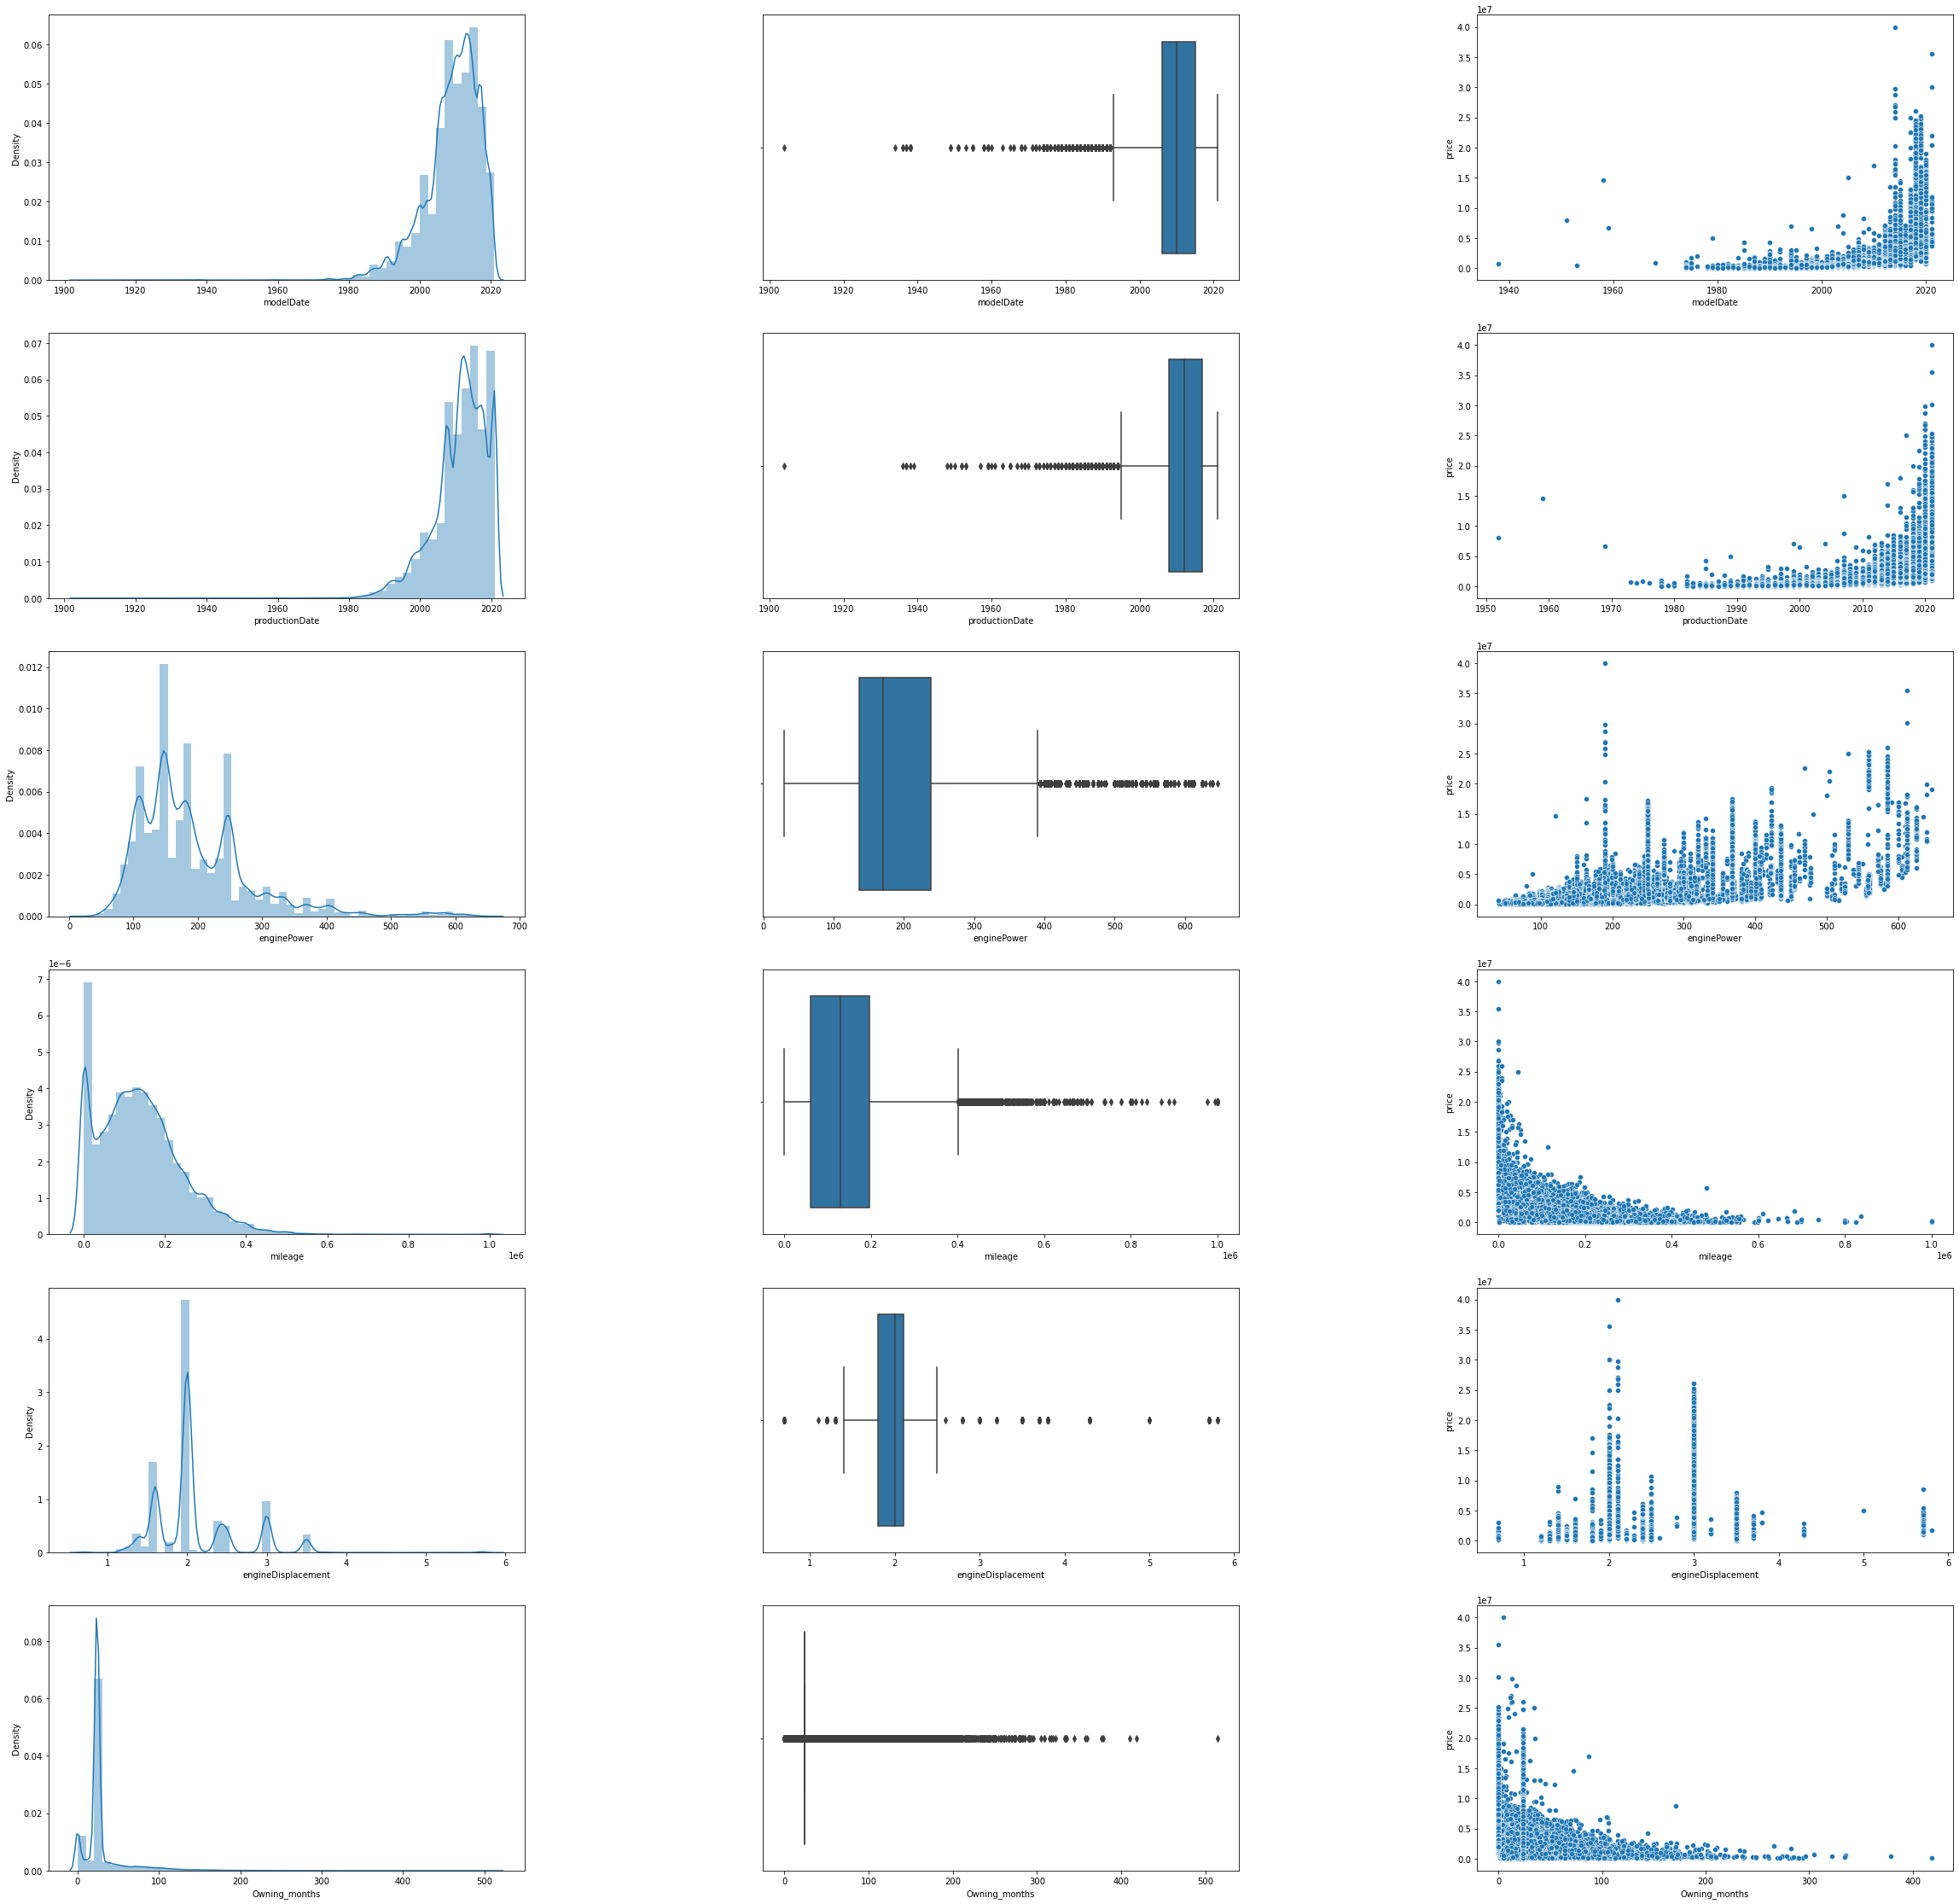

In [122]:
# Построим распределение основных числовых признаков

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(6, 3, figsize=(40, 40))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1
    sns.boxplot(data[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=data[data['Sample'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1

In [123]:
print("Основные параметры статистики для числовых признаков.")
display(data[num_cols].describe())

Основные параметры статистики для числовых признаков.


,modelDate,productionDate,enginePower,mileage,engineDisplacement,Owning_months
count,71272.000000,71272.000000,71272.000000,71272.000000,71272.000000,71272.000000
mean,2009.218262,2011.369388,191.484005,138653.048504,2.094332,29.164511
std,7.568253,7.322784,88.290463,103441.660302,0.531589,27.738393
min,1904.000000,1904.000000,30.000000,0.000000,0.700000,0.000000
25%,2006.000000,2008.000000,136.000000,61350.000000,1.800000,24.000000
50%,2010.000000,2012.000000,170.000000,129000.000000,2.000000,24.000000
75%,2015.000000,2017.000000,239.000000,197220.250000,2.100000,24.000000
max,2021.000000,2021.000000,646.000000,1000000.000000,5.800000,514.000000


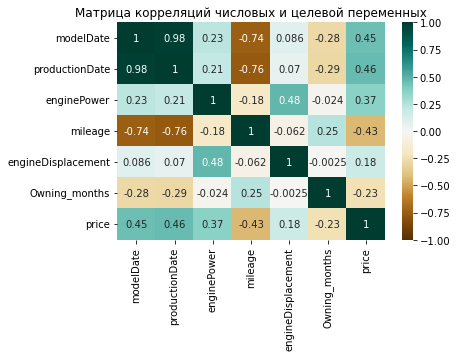

In [124]:
# Построим матрицу корреляций числовых признаков с целевой переменной
heatmap = sns.heatmap(data[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

**Выводы:**
* **modelDate**
Удалить параметр. Большая корреляция с productionDate.
* **productionDate**
Распределение нормальное, сильно  смещенное вправо к новым автомобилям.
* **mileage**
Смещенное нормальное распределение.
* **engineDisplacement**
Объем двигателя. Распределение близко к нормальному. Возможно разбить на категории по интервалам?

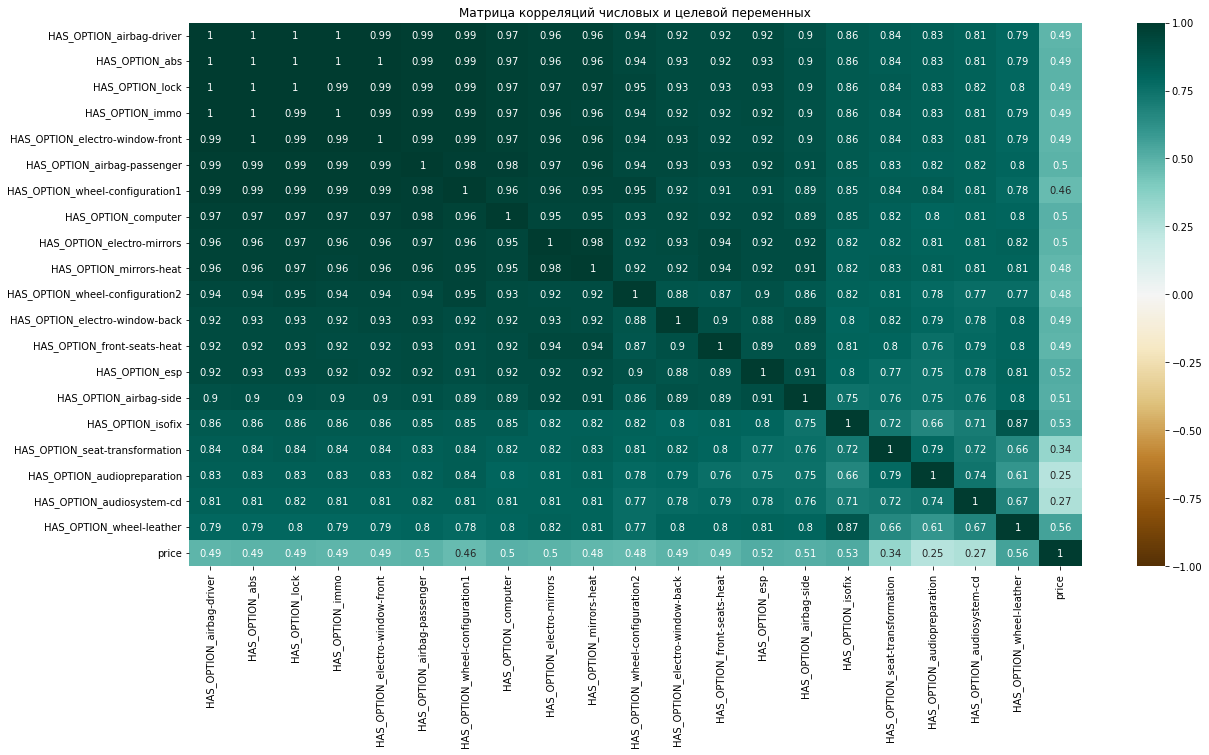

In [125]:
# Построим матрицу корреляций
rcParams['figure.figsize'] = 20, 10

heatmap = sns.heatmap(data[num_cols_01 + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

Видим, что корреляция высокая между собой и можно удалить признаки где корреляция больше 0,8

In [126]:
# удалим признаки с высокой корреляцией между собой и низкой корреляцией с целевой переменной
data.drop(['HAS_OPTION_airbag-driver', 'HAS_OPTION_abs', 'HAS_OPTION_lock',
           'HAS_OPTION_immo', 'HAS_OPTION_electro-window-front', 'HAS_OPTION_airbag-passenger',
           'HAS_OPTION_wheel-configuration1','HAS_OPTION_computer','HAS_OPTION_electro-mirrors',
           'HAS_OPTION_mirrors-heat','HAS_OPTION_wheel-configuration2','HAS_OPTION_electro-window-back',
           'HAS_OPTION_front-seats-heat','HAS_OPTION_esp', 'HAS_OPTION_airbag-side',
           'HAS_OPTION_seat-transformation','HAS_OPTION_audiopreparation',
           'HAS_OPTION_audiosystem-cd'], axis=1, inplace=True)

## Категориальные и бинарные переменные: конвертация в числовые

In [127]:
# pip install -U seaborn

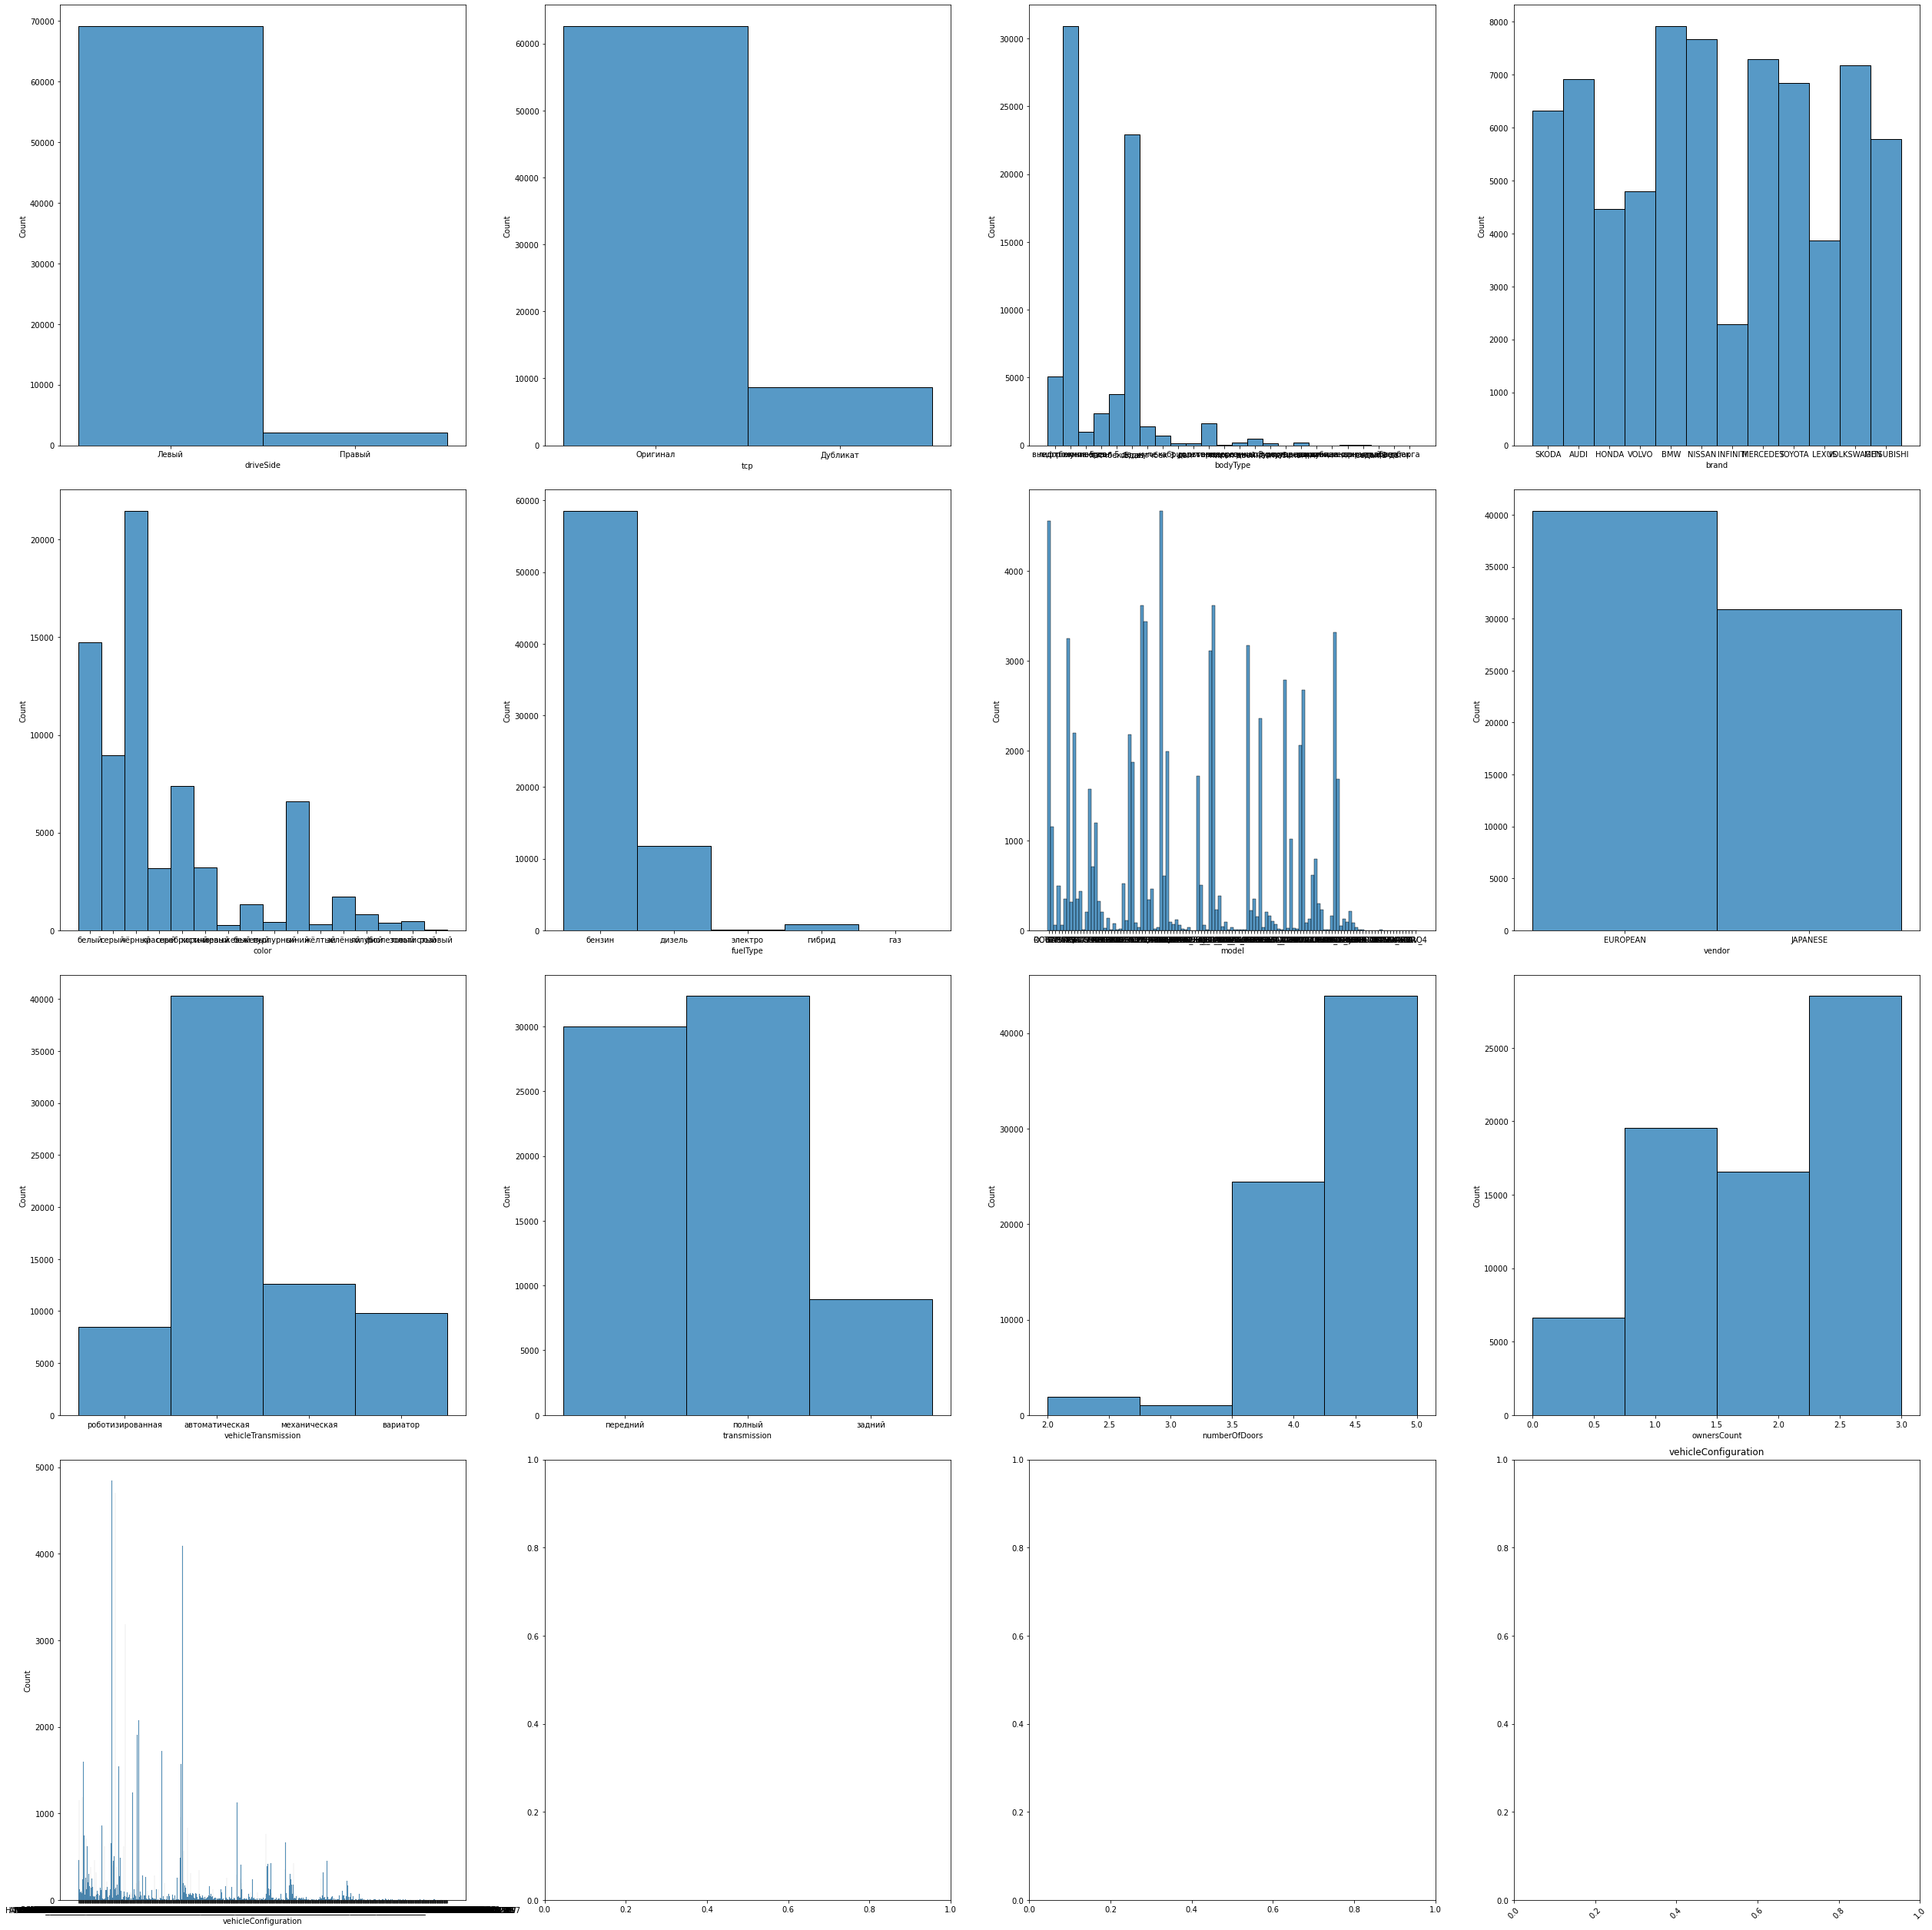

In [128]:
# Построим распределение основных бинарных и категориальных признаков

fig, axes = plt.subplots(4, 4, figsize=(35, 35))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(data=data, x=data[col], ax=axes[i],
                 stat='count', bins=data[col].nunique())
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.title(col)
    i = i + 1

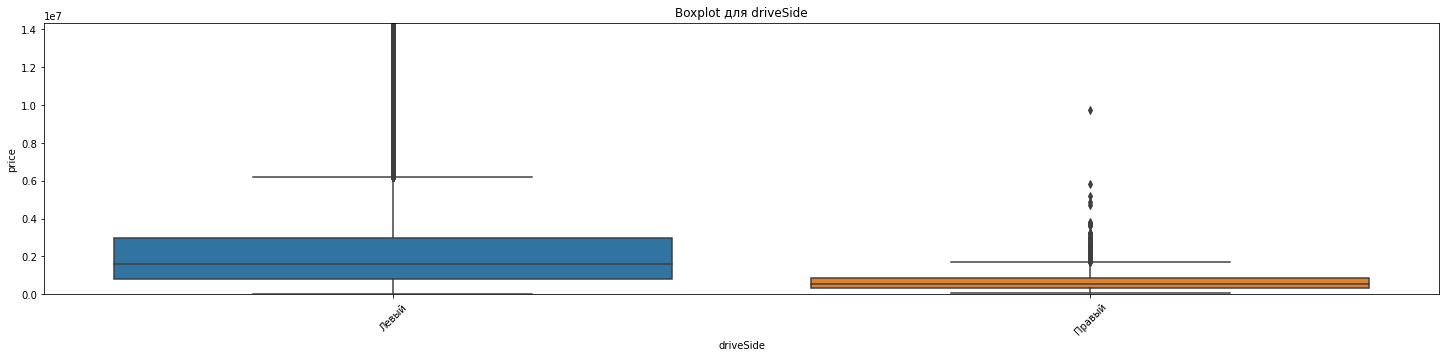

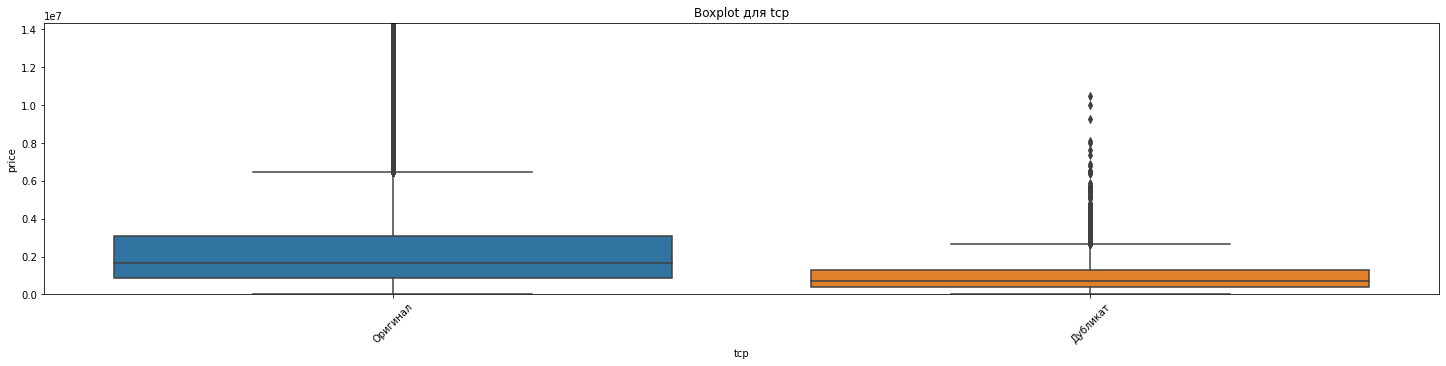

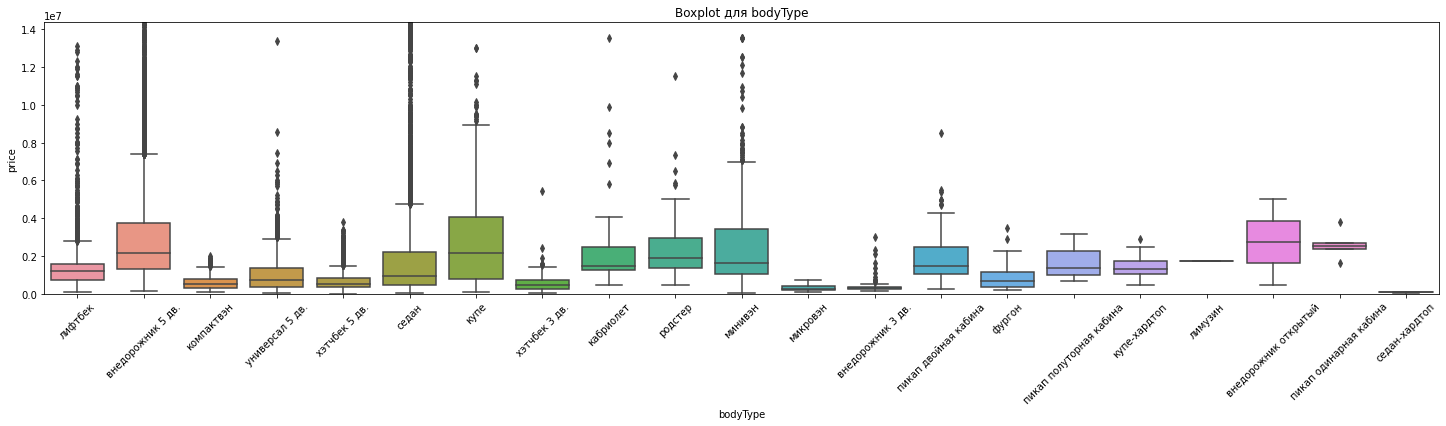

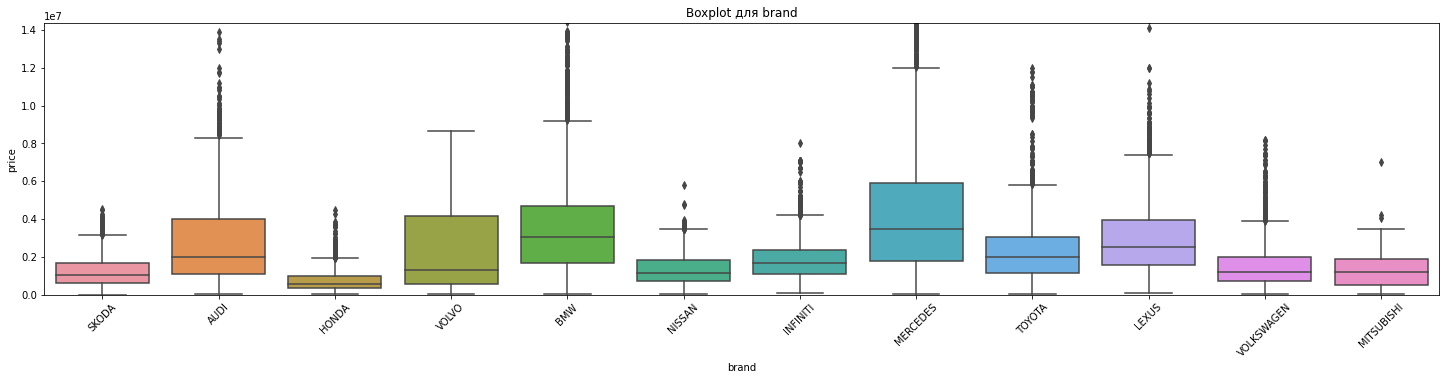

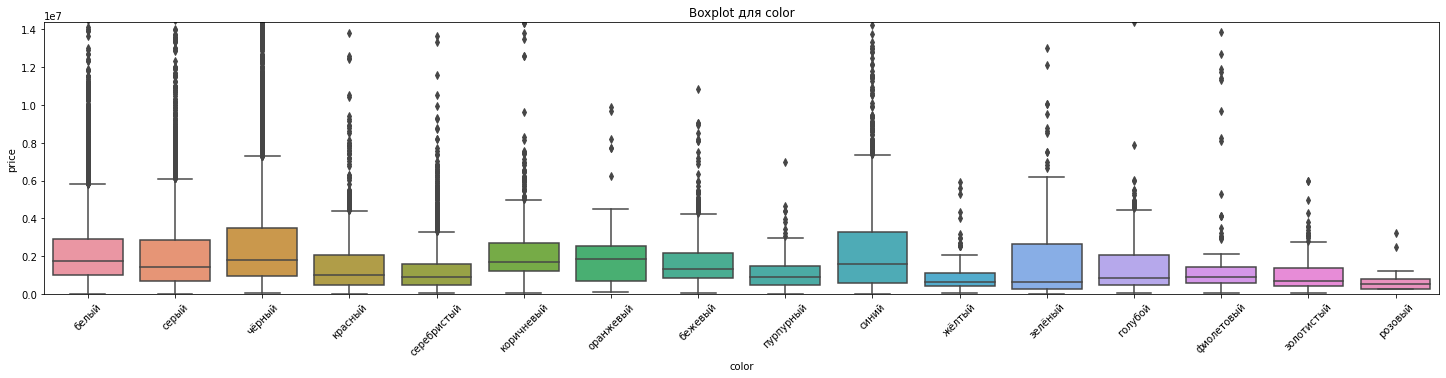

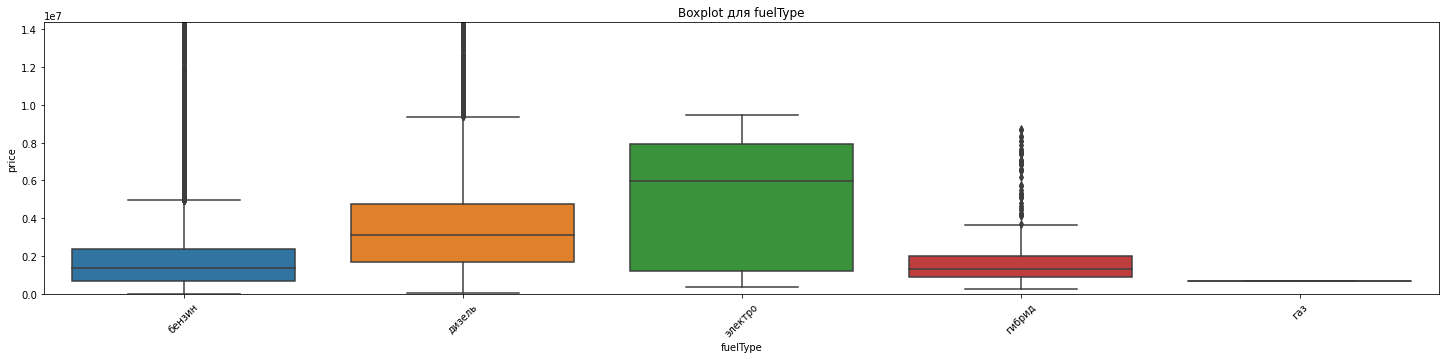

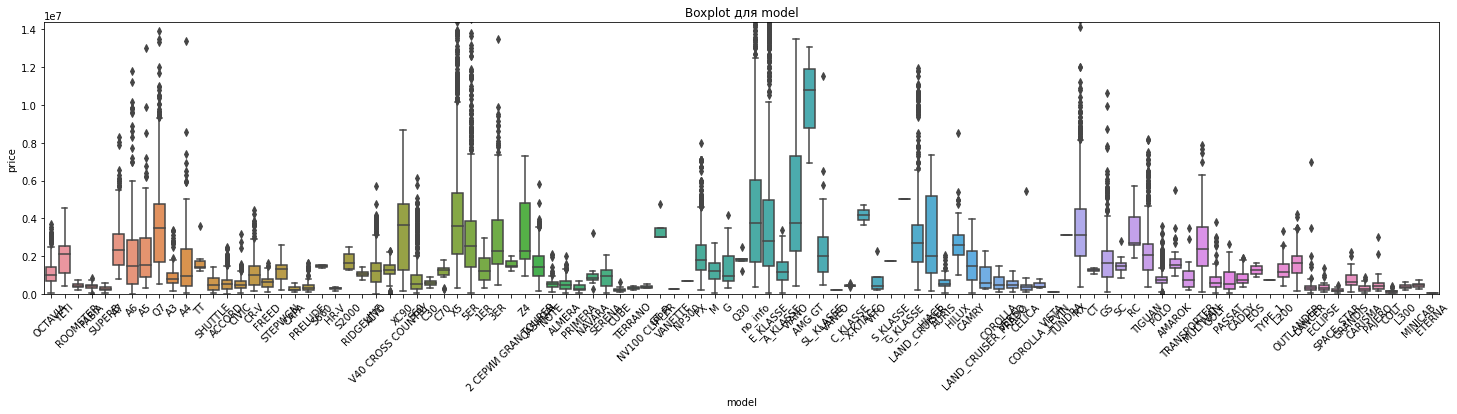

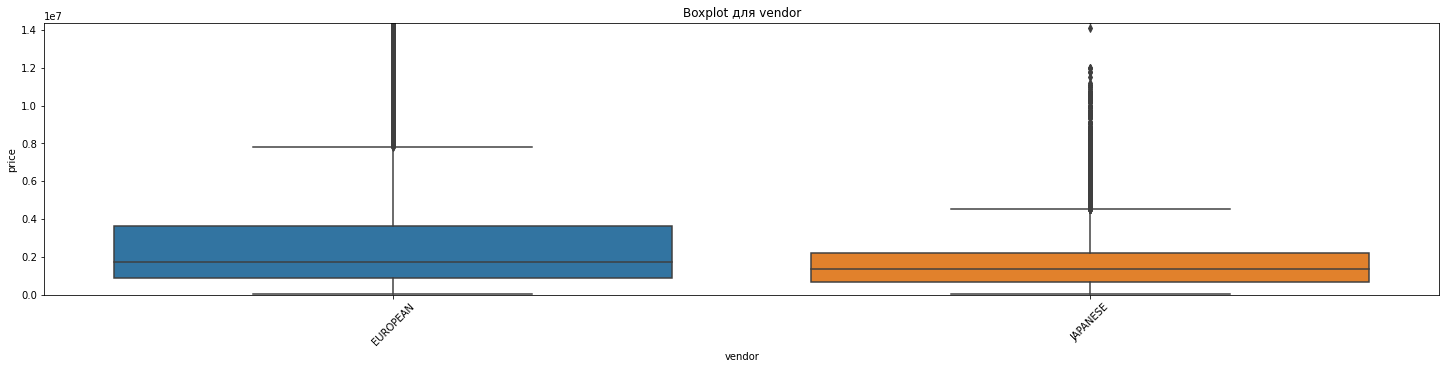

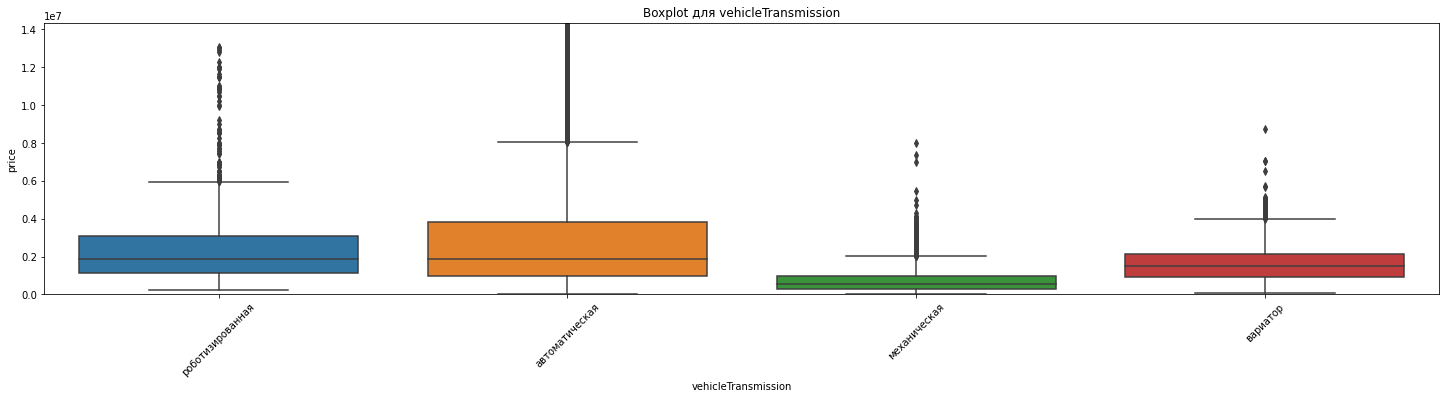

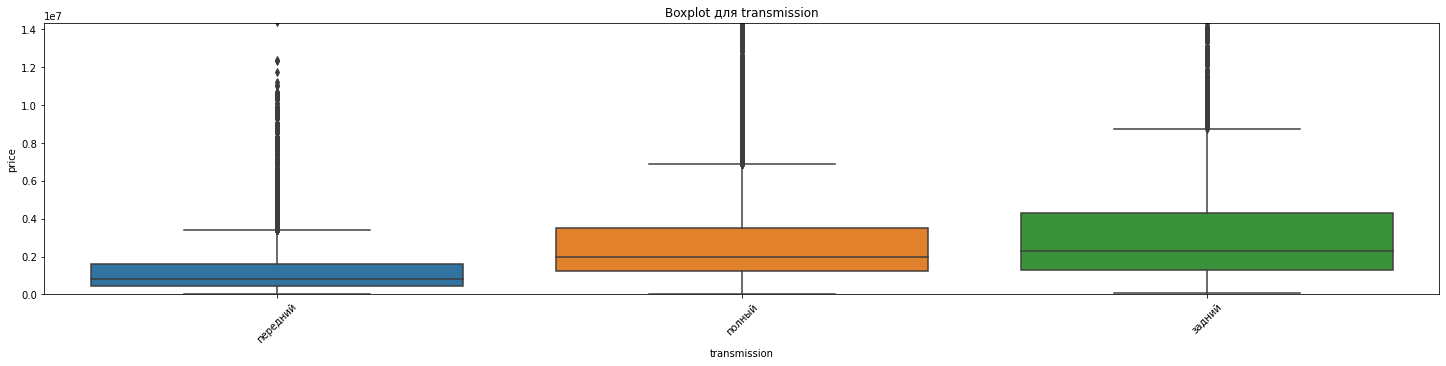

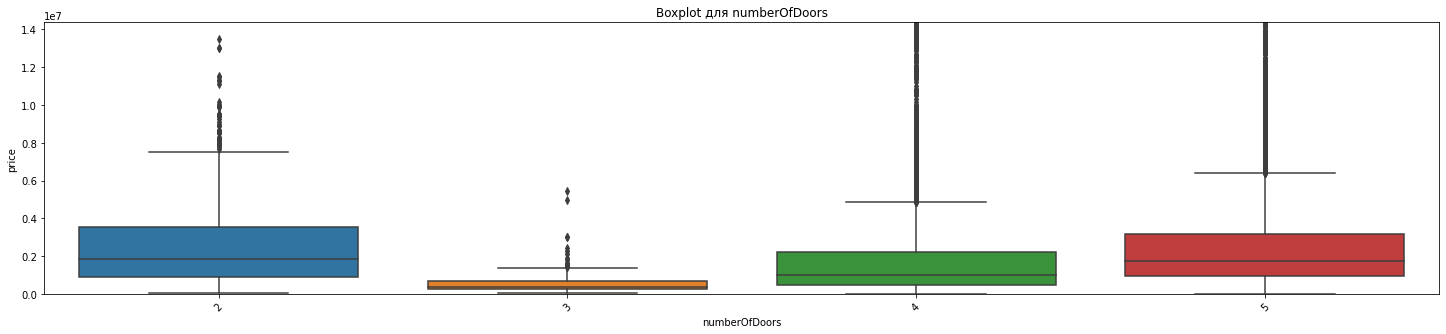

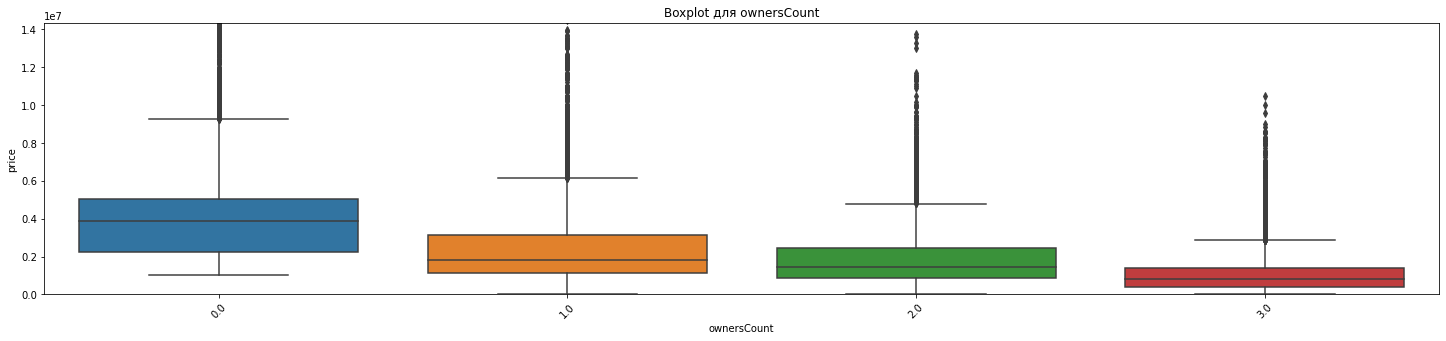

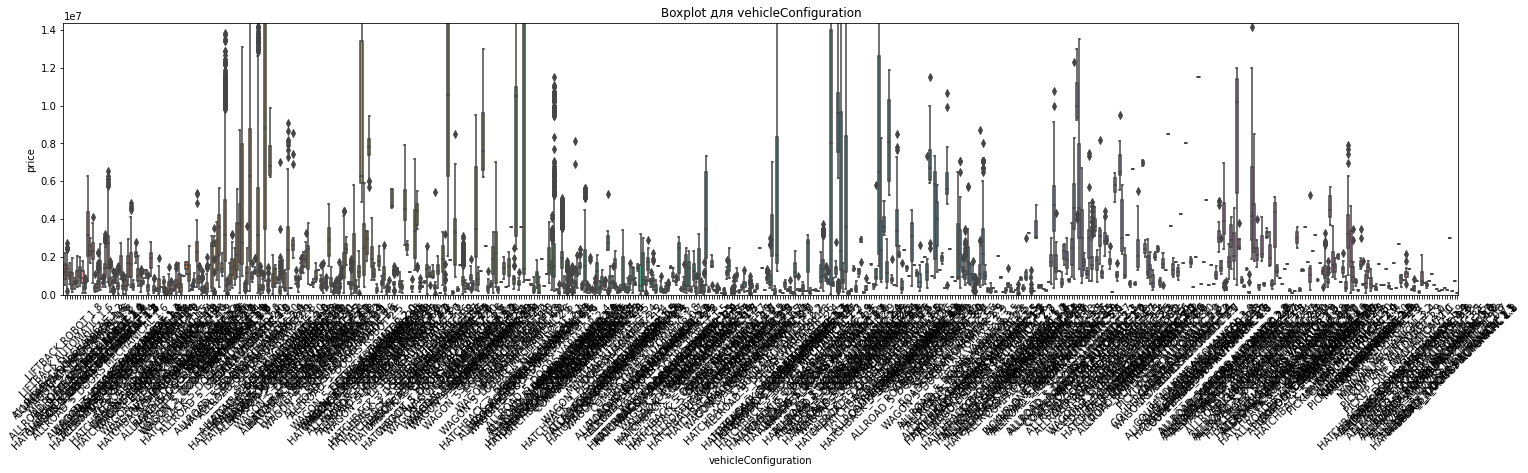

In [129]:
# Построим график boxplot

for col in (bin_cols + cat_cols):    
    get_boxplot(col)

Выводы по графикам:

Абсолютно сбалансированные признаки отсутсвуют.
Плохо сбалансированные признаки:
- driveSide - левосторонних машин больше
- bodyType - некоторые категории представлены небольшим количеством машин, boxplot показывает значительные различия и распределение по ценам 
- brand - много категорий, самыое популярное авто - Mercedes 
- color - есть популярные цвета (черный, белый, серый, серебристый, синий) и редкие. Можно создать новый признак о популярности цвета
- fuelType - есть типы топлива, которые в явном меньшинстве. Может стоит делать группировку непопулярных типов топлива
- tcp - несбалансированный признак, но пока оставляем в модели
- model - очень много уникальных категорий, подумать, можно ли как-то доработать признак
- numberOfDoors - малое количество машин в диапозоне 0-3 дверей

Сбалансированные признаки:

- transmission - автомат в большинстве
- drivertrain - передний привод встречается чаще всего
- vendor - большее количество автомобилей европейского региона
- ownersCount - привалирует 3 и более.

Зависимость с целевой переменной:

- driveSide: авто с правосторонним рулем в среднем дешевле машин с левосторонним рулем
- transmission: авто с АТ коробкой намного дороже MT, как и сам диапазон цен
- bodyType: признак, который значительно влияет на распределение цен
- brand: большая разбежка цен от бренда. Выделяются престижные авто (porche, Cadillac, bmw, and Rover, Lexus и др), а есть дешевый сегмент (азиатские авто - Cherry, Daewoo, Great wall и др.).
- color: цены зависят от цвета
- fuelType: очень дорогие машины электро и дизель
- drivetrain: полноприводные машины дороже всех, заднеприводные машины в среднем дешевле переднеприводных
- tcp: авто с дубликатом ПТС дешевле чем те, что с оригиналом
- model - данных много, но видно, что есть колебания цены в зависимости от модели
- vendor: в среднем, европейские и японские машины дороже американских и азиатских
- vehicleTransmission: в среднем разновидности автоматов особо не влияют на цену, проверить значимость признака тестом Стьюдента. 
- numberOfDoors: в среднем самые дорогие авто - 2-х дверные, затем 5-дверные.

# Преобразование бинарных переменных в числа

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа. Применим LabelEncoder ко всему набору бинарных переменных.

In [130]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data[bin_cols].sample(6)

,driveSide,tcp
3263,0,1
33182,0,1
662,0,1
64616,0,1
52532,0,1
52555,0,1


# Целевая переменная Price

In [131]:
# посмотрим на целевую переменную в train
print(data[data.Sample == 1]['price'].describe())

count    3.658600e+04
mean     2.244506e+06
std      2.389554e+06
min      2.300000e+04
25%      7.870000e+05
50%      1.550000e+06
75%      2.883750e+06
max      3.999000e+07
Name: price, dtype: float64


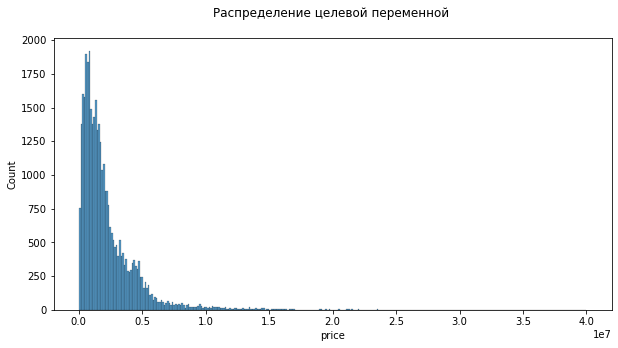

In [132]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.Sample == 1], x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

Добавляем новый признак, взяв логарифм от цены, чтобы нормализовать распределение

In [133]:
# Добавляем новый признка
data['price_log'] = data['price'].apply(lambda x: np.log(x))

# Добавим новый признак в список целевых
target_col.append('price_log')

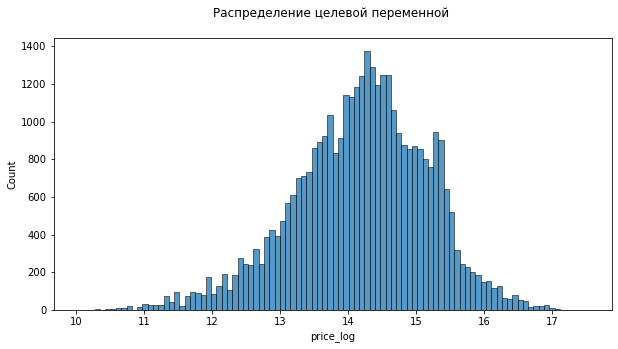

In [134]:
# Посмотрим, как изменилось распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.Sample == 1], x='price_log')
plt.title("Распределение целевой переменной \n")
plt.show()

# Обработка выбросов

In [135]:
# Проанализируем выбросы для категориальных и номинативных признаков
print("Отчет о наличии выбросов в датасете.\n")
for col in (num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_analysis(data[col])
    print("-" * 100)

Отчет о наличии выбросов в датасете.


Признак:  modelDate

25-й перцентиль: 2006.0, 
75-й перцентиль: 2015.0, 
IQR: 9.0,  
Границы выбросов: [1992.5, 2028.5]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2021 .

Найдены выбросы по нижней границе признака! Количество: 2524, 3.54%
----------------------------------------------------------------------------------------------------

Признак:  productionDate

25-й перцентиль: 2008.0, 
75-й перцентиль: 2017.0, 
IQR: 9.0,  
Границы выбросов: [1994.5, 2030.5]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2021 .

Найдены выбросы по нижней границе признака! Количество: 2175, 3.05%
----------------------------------------------------------------------------------------------------

Признак:  enginePower

25-й перцентиль: 136.0, 
75-й перцентиль: 239.0, 
IQR: 103.0,  
Границы выбросов: [-18.5, 393.5]. 

Минимальное значение признака: 30. 
Максимальное значение признака: 646 .

Найдены выбросы 

**Выводы:**

* В test выборке есть значения с рарититными авто - оставляем выбросы по признакам modelDate, productionDate.
* По остальным выбросам проведем анализ и обработку.

**Признак:  enginePower**

25-й перцентиль: 136.0, 
75-й перцентиль: 239.0, 
IQR: 103.0,  
Границы выбросов: [-18.5, 393.5]. 

Минимальное значение признака: 30. 
Максимальное значение признака: 639 .

Найдены выбросы по верхней границе признака! Количество: 2547, 3.58%

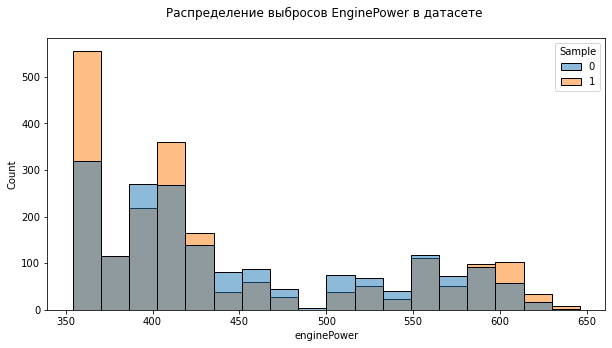

In [136]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.enginePower > 352)], x='enginePower', hue = 'Sample')
plt.title("Распределение выбросов EnginePower в датасете \n")
plt.show()

Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям enginePower
Цена варьтруется и увеличивается с увеличением мощности двигателя, заменять выбросы на другую величину не стоит

**Признак:  mileage**

25-й перцентиль: 61500.0, 
75-й перцентиль: 197265.0, 
IQR: 135765.0,  
Границы выбросов: [-142147.5, 400912.5]. 

Минимальное значение признака: 0.0. 
Максимальное значение признака: 1000000.0 .

Найдены выбросы по верхней границе признака! Количество: 1049, 1.47%

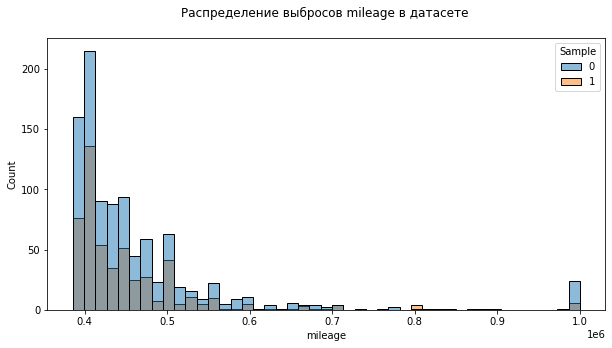

In [137]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.mileage > 385000)], x='mileage', hue = 'Sample')
plt.title("Распределение выбросов mileage в датасете \n")
plt.show()

Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям mileage
Цена варьтруется и снижается с увеличением пробега.

**Признак:  engineDisplacement**

25-й перцентиль: 1.8, 
75-й перцентиль: 3.0, 
IQR: 1.2,  
Границы выбросов: [2.220446049250313e-16, 4.8]. 

Минимальное значение признака: 0.7. 
Максимальное значение признака: 6.6 .

Найдены выбросы по верхней границе признака! Количество: 1958, 2.75%

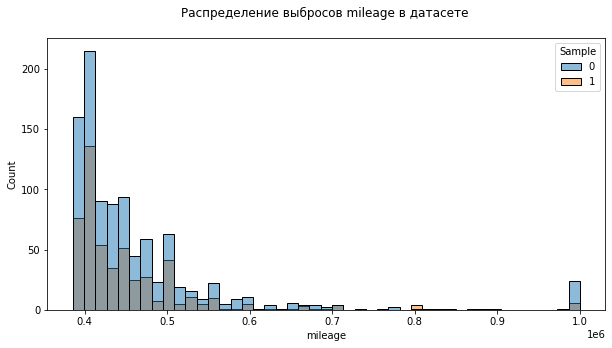

In [138]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.mileage > 385000)], x='mileage', hue = 'Sample')
plt.title("Распределение выбросов mileage в датасете \n")
plt.show()

Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя.

**Признак:  price**

25-й перцентиль: 0.0, 
75-й перцентиль: 1590000.0, 
IQR: 1590000.0,  
Границы выбросов: [-2385000.0, 3975000.0]. 

Минимальное значение признака: 0.0. 
Максимальное значение признака: 39990000.0 .

Найдены выбросы по верхней границе признака! Количество: 5629, 7.91%

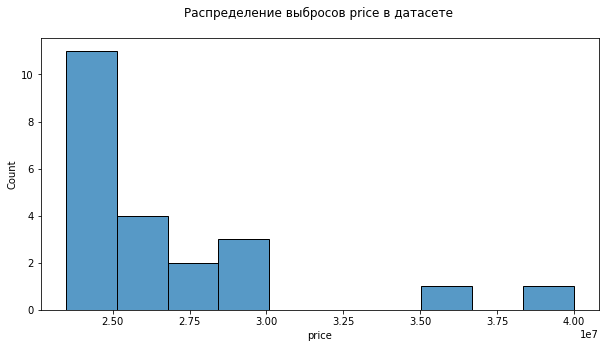

In [139]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.price > 23362500)&(data.Sample == 1)], x='price')
plt.title("Распределение выбросов price в датасете \n")
plt.show()

Вывод: есть очень дорогие авто, которые представлены и в тестовой выборке.

## Логарифмирование числовых признаков

Многие числовые признаки имеют смещенное распределение влево/вправо попробуем логарифмировать их.

In [140]:
cols_to_log = ['modelDate', 'productionDate', 
            'enginePower', 'mileage', 'engineDisplacement', 'Owning_months']
# Применим логарифмирование ко всем числовым признакам
for col in cols_to_log:
    data[col] = data[col].apply(lambda w: np.log(w+1))

Диаграмы распределения числовых признаков после логарифмирования.


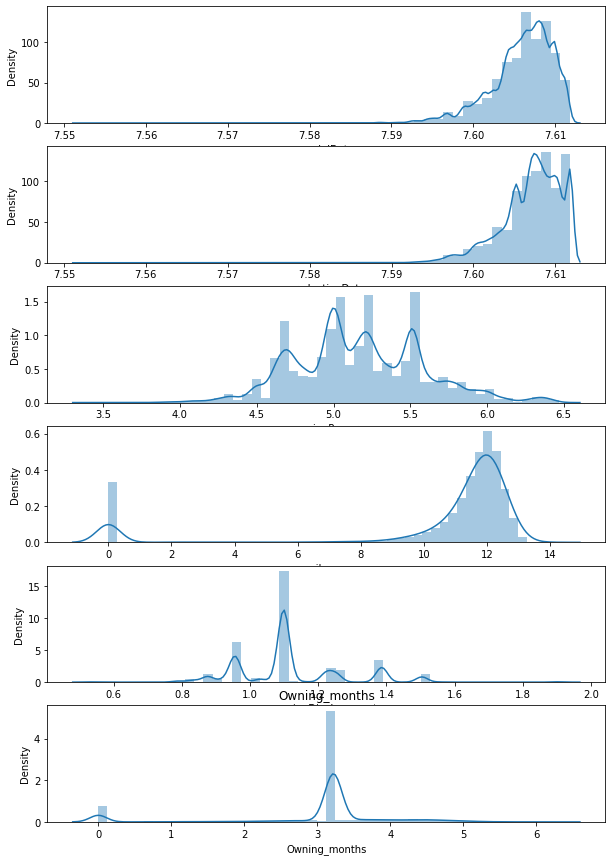

In [141]:
# Посмотрим, как изменилось распределение
print("Диаграмы распределения числовых признаков после логарифмирования.")
fig, axes = plt.subplots(len(cols_to_log), figsize=(10, 15))
axes = axes.flatten()
i = 0

for col in cols_to_log:
    sns.distplot(data[col], ax=axes[i])
    plt.title(col)
    i = i + 1

Вывод: логарифмирование позволило привести признаки к более нормальному распределению, поэтому оставляем их в таком виде

# Отбор признаков для моделирования

Проведем корреляционный анализ числовых признаков

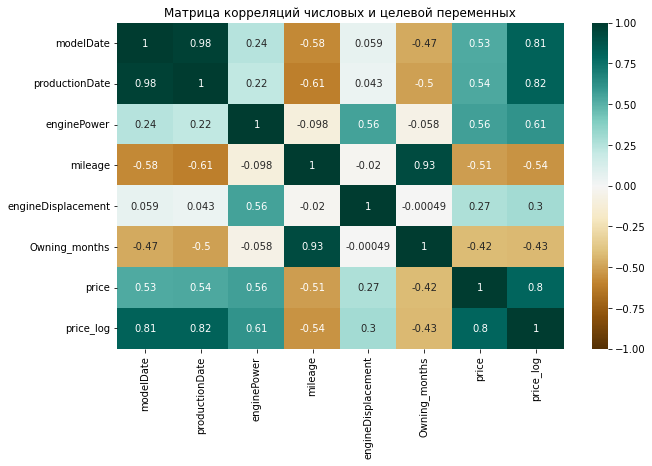

In [142]:
# Построим матрицу корреляций
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(data[data['Sample'] == 1][num_cols +
                                               target_col].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

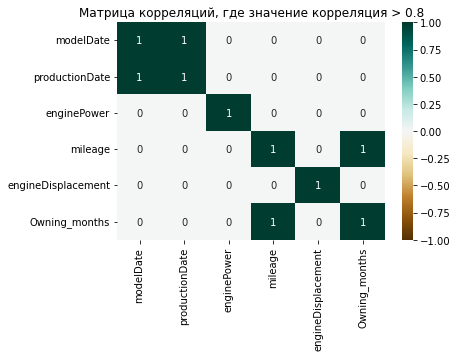

In [143]:
# Подсветим те значения, где коэффициент корреляции больше заданного порога
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(abs(data[data['Sample'] == 1][num_cols].corr(
)) > 0.8, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций, где значение корреляция > 0.8')
plt.show()

In [144]:
# удалим modelDate, так как она коррелирует с productionDate
data.drop('modelDate', axis=1, inplace=True)

In [145]:
# обновим числовые переменные
num_cols = ['productionDate', 
            'enginePower', 'mileage', 'engineDisplacement', 'Owning_months']

Сформируем список признаков, которые коллинеарны. Для этого выставим критерий наличия корреляции больше 0.8 или -0.8.

In [146]:
# Сформируем сет со скоррелированными признаками
correlated_features = set()

# Удаляем целевые и служебные переменные из матрицы коррелиций, тк корреляция с ней, - хорошо для модели
correlation_matrix = data[data['Sample'] == 1][num_cols].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

print('Список скоррелированных признаков на удаление из обучения модели:',
      correlated_features)

Список скоррелированных признаков на удаление из обучения модели: {'mileage'}


In [147]:
# удалим Owning_months, так как она коррелирует с productionDate
data.drop('Owning_months', axis=1, inplace=True)

In [148]:
# обновить числовые переменные
num_cols = ['modelDate', 'productionDate', 
            'enginePower', 'mileage', 'engineDisplacement']

In [149]:
print("После обработки остались следующие признаки:", data.columns)

После обработки остались следующие признаки: Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'model', 'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'ownersCount',
       'tcp', 'transmission', 'driveSide', 'price', 'HAS_OPTION_isofix',
       'HAS_OPTION_wheel-leather', 'Sample', 'price_log'],
      dtype='object')


# Кодирование категориальных признаков
## Label Encoding

In [150]:
# применяем Labels encoding ко всем категориальным признакам
cols_to_encode = list(set(data.columns) & set(cat_cols))
for colum in cols_to_encode:
    data[colum] = data[colum].astype('category').cat.codes

Поиск статистически значимых различий с помощью теста Стьюдента

In [151]:
# Создадим список с колонками, которые удалим из данных ввиду их статистической незначимости
cat_cols_remove = []

# Проходим по колонкам, которые исключали из корреляционного анализа
for column in (list(set(data.columns).difference(num_cols+ num_cols_01+service_cols+target_col))):
    #print("\n\nПроверяется колонка:", column)
    cat_cols_remove.append(get_stat_dif(column))

Не найдены статистически значимые различия для колонки и комбинации color (15, 8)
Не найдены статистически значимые различия для колонки и комбинации fuelType (0, 2)
Не найдены статистически значимые различия для колонки и комбинации brand (7, 6)
Не найдены статистически значимые различия для колонки и комбинации bodyType (1, 10)
Не найдены статистически значимые различия для колонки и комбинации model (79, 70)
Не найдены статистически значимые различия для колонки и комбинации vehicleConfiguration (41, 513)


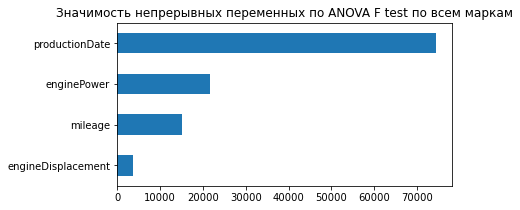

In [152]:
#Оценим значимость числовых признаков
fig, ax = plt.subplots(figsize=(6, 3))
anova_df = data[data['Sample'] == 1].dropna().copy()
imp_num = pd.Series(f_regression(anova_df[list(set(data.columns) & set(num_cols))], anova_df['price_log'])[
                    0], index=list(set(data.columns) & set(num_cols)))
imp_num.sort_values(inplace=True)
imp_num.plot(
    kind='barh', title='Значимость непрерывных переменных по ANOVA F test по всем маркам')
plt.show()

# Предварительный анализ ML

In [153]:
# Стандартизация числовых переменных
cols_to_scale = list(set(data.columns) & set(num_cols))
data[cols_to_scale] = StandardScaler().fit_transform(data[cols_to_scale].values)

In [154]:
# # Выделим тестовую и тренировочную часть
X = data.query('Sample == 1').drop(
    ['Sample', 'price','price_log'], axis=1)
X_sub = data.query('Sample == 0').drop(
    ['Sample', 'price', 'price_log'], axis=1)

In [155]:
# В качестве y указываем обычную цену
y = data[data.Sample== 1]['price']

In [156]:
# train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Модель 1 - Наивная модель

Эта модель будет предсказывать среднюю цену по модели двигателя (mileage). C ней будем сравнивать другие модели.

In [157]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [158]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 73.30%


## Модель 2 - CatBoost

In [159]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [160]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 13.12%


Log Target

In [161]:
np.log(y_train)

19957    14.530908
33907    13.176852
12574    13.864301
15521    15.590463
32230    14.710945
           ...    
16850    14.928683
6265     15.872219
11284    15.299764
860      13.444447
15795    12.429216
Name: price, Length: 29268, dtype: float64

In [162]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_2_baseline.model')

In [163]:
predict_test = np.exp(model.predict(X_test))

In [164]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.81%


## Модель 3 - RandomForestRegressor

In [165]:
# Построим модель на дефолтных параметрах
# без логарифмирования целевой переменной
rf = RandomForestRegressor(random_state = RANDOM_SEED)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
rf_log.fit(X_train, np.log(y_train))
rf_log_pred = np.exp(rf_log.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 12.95%
Точность модели по метрике MAPE с логтаргетом: 12.16%


In [166]:
# Попробуем подобрать гиперпараметры для нашей модели

random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)

rf_random.fit(X_train, np.log(y_train))
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 15,
 'bootstrap': False}

In [167]:
# Обучим модель на лучших гиперпараметрах

#best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=400
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='log2'
                      , max_depth=15
                      , bootstrap=False)

# best_rfr.fit(X_train, y_train)
best_rfr.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
predict_rfr = np.exp(best_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.07%


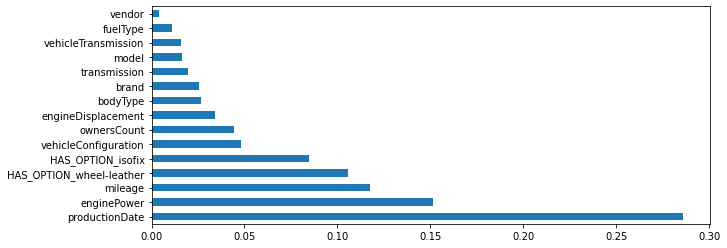

In [168]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,4)
feat_importances = pd.Series(best_rfr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

## Модель 4 - XGBRegressor

In [169]:
# можно попробовать менять learning_rate (0.05, 0.03, 0.01), max_depth (3,5,8,12,24,36)

# без логарифмирования целевой переменной
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
xgb_reg.fit(X_train, y_train)
print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, xgb_reg.predict(X_test)))*100:0.2f}%")

#с логарифмированием целевой переменной
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
xgb_reg.fit(X_train, np.log(y_train))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, np.exp(xgb_reg.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 13.54%
Точность модели по метрике MAPE с логтаргетом: 11.99%


In [170]:
# Попробуем с логарифмом таргета разную глубину

def xgb_reg_learn(depth):
    xgb_list = []
    for i in depth:
        xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                                        learning_rate=0.05, max_depth=i, alpha=1,
                                        n_estimators=1000)
        xgb_reg.fit(X_train, np.log(y_train))
        xgb_list.append(xgb_reg)
        print(
            f"Точность модели по метрике MAPE с логтаргетом и max_depth={i}: {(mape(y_test, np.exp(xgb_reg.predict(X_test))))*100:0.2f}%")
    return xgb_list

depth = [3,5,8,12,24,36]
xgb_list = xgb_reg_learn(depth)

Точность модели по метрике MAPE с логтаргетом и max_depth=3: 13.36%
Точность модели по метрике MAPE с логтаргетом и max_depth=5: 12.20%
Точность модели по метрике MAPE с логтаргетом и max_depth=8: 11.89%
Точность модели по метрике MAPE с логтаргетом и max_depth=12: 11.99%
Точность модели по метрике MAPE с логтаргетом и max_depth=24: 12.04%
Точность модели по метрике MAPE с логтаргетом и max_depth=36: 12.06%


In [171]:
# Параметры лучшей модели
best_xgb = xgb_list[2]
best_xgb

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

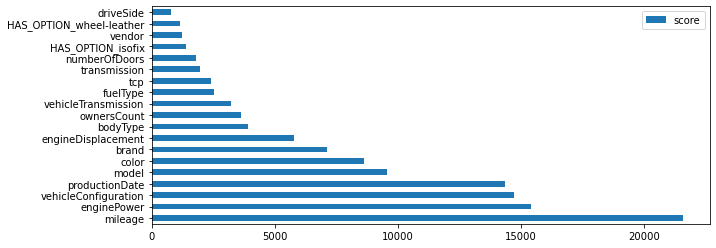

In [172]:
feature_important = best_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh');

## Модель 5 - ExtraTreesRegressor

In [173]:
#Построим модель на дефолтных параметрах

# без логарифмирования целевой переменной
etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
etr.fit(X_train, y_train)
etr_pred = etr.predict(X_test)

print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, etr_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
etr.fit(X_train, np.log(y_train))
etr_pred = np.exp(etr.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, etr_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 13.43%
Точность модели по метрике MAPE с логтаргетом: 12.46%


In [174]:
# Попробуем подобрать гиперпараметры для нашей модели

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
               'max_features': ['auto', 'sqrt','log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
etr_random = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
# rf_random.fit(X_train, y_train)
etr_random.fit(X_train, np.log(y_train))
etr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15,
 'bootstrap': False}

In [175]:
# Обучим модель на лучших гиперпараметрах

best_etr = ExtraTreesRegressor(random_state=RANDOM_SEED,
                               n_estimators=100,
                               min_samples_split=5,
                               min_samples_leaf=1,
                               max_features='auto',
                               max_depth=15,
                               bootstrap=False)
best_etr.fit(X_train, np.log(y_train))

predict_etr = np.exp(best_etr.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.00%


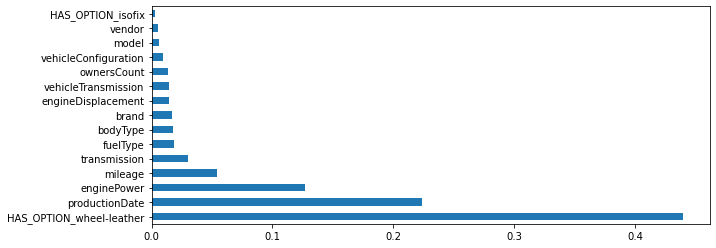

In [176]:
plt.rcParams['figure.figsize'] = (10,4)
feat_importances = pd.Series(best_etr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

## Модель 6 - BaggingRegressor

### с RandomForest

In [177]:
#best_rfr
RandomForestRegressor(n_estimators=300, random_state=42)

RandomForestRegressor(n_estimators=300, random_state=42)

In [178]:
# Обучим на дефолтных параметрах

bagg_rfr_d = BaggingRegressor(best_rfr, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr_d.fit(X_train, np.log(y_train))
predict_bagg_rfr_d = np.exp(bagg_rfr_d.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_rfr_d))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.25%


In [179]:
# Добавим к параметрам n_estimators=3

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.36%


### с ExtraTreesRegressor

In [180]:
# etr
ExtraTreesRegressor(random_state=42)

ExtraTreesRegressor(random_state=42)

In [181]:
# Обучим на дефолтных параметрах

bagg_etr = BaggingRegressor(etr, n_jobs=1, random_state=RANDOM_SEED)
bagg_etr.fit(X_train, np.log(y_train))
predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.04%


In [182]:
# Добавим к параметрам n_estimators=3

bagg_etr = BaggingRegressor(etr, n_jobs=1, n_estimators = 3, random_state=RANDOM_SEED)
bagg_etr.fit(X_train, np.log(y_train))
predict_bagg_etr = np.exp(bagg_etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_bagg_etr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.31%


## Модель 7 - StackingRegressor

### Xgboosting, ExtraTreesRegressor+LinearRegression

In [183]:
estimators = [('etr',ExtraTreesRegressor()),
              ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 11.81%


### Xgboosting, ExtraTreesRegressor+CatBoostRegressor

In [184]:
estimators = [('etr',ExtraTreesRegressor()),
              ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators,final_estimator=CatBoostRegressor())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Learning rate set to 0.069802
0:	learn: 0.9221437	total: 53ms	remaining: 53s
1:	learn: 0.8638597	total: 59ms	remaining: 29.4s
2:	learn: 0.8098079	total: 64.3ms	remaining: 21.4s
3:	learn: 0.7600490	total: 69.1ms	remaining: 17.2s
4:	learn: 0.7136498	total: 73.7ms	remaining: 14.7s
5:	learn: 0.6699195	total: 78.4ms	remaining: 13s
6:	learn: 0.6296743	total: 83.1ms	remaining: 11.8s
7:	learn: 0.5919443	total: 87.9ms	remaining: 10.9s
8:	learn: 0.5572103	total: 94.7ms	remaining: 10.4s
9:	learn: 0.5249479	total: 99.8ms	remaining: 9.88s
10:	learn: 0.4950901	total: 105ms	remaining: 9.45s
11:	learn: 0.4676909	total: 110ms	remaining: 9.09s
12:	learn: 0.4422333	total: 116ms	remaining: 8.83s
13:	learn: 0.4186842	total: 123ms	remaining: 8.65s
14:	learn: 0.3972218	total: 129ms	remaining: 8.5s
15:	learn: 0.3775048	total: 135ms	remaining: 8.28s
16:	learn: 0.3592135	total: 140ms	remaining: 8.07s
17:	learn: 0.3423952	total: 144ms	remaining: 7.87s
18:	learn: 0.3266851	total: 149ms	remaining: 7.71s
19:	learn:

189:	learn: 0.1820595	total: 899ms	remaining: 3.83s
190:	learn: 0.1820477	total: 904ms	remaining: 3.83s
191:	learn: 0.1820181	total: 909ms	remaining: 3.83s
192:	learn: 0.1819955	total: 914ms	remaining: 3.82s
193:	learn: 0.1819713	total: 920ms	remaining: 3.82s
194:	learn: 0.1819625	total: 924ms	remaining: 3.81s
195:	learn: 0.1819475	total: 929ms	remaining: 3.81s
196:	learn: 0.1819358	total: 933ms	remaining: 3.8s
197:	learn: 0.1819264	total: 937ms	remaining: 3.79s
198:	learn: 0.1818863	total: 941ms	remaining: 3.79s
199:	learn: 0.1818625	total: 945ms	remaining: 3.78s
200:	learn: 0.1818345	total: 949ms	remaining: 3.77s
201:	learn: 0.1818281	total: 953ms	remaining: 3.76s
202:	learn: 0.1818084	total: 957ms	remaining: 3.76s
203:	learn: 0.1817743	total: 961ms	remaining: 3.75s
204:	learn: 0.1817517	total: 965ms	remaining: 3.74s
205:	learn: 0.1817347	total: 969ms	remaining: 3.73s
206:	learn: 0.1817189	total: 973ms	remaining: 3.73s
207:	learn: 0.1817054	total: 978ms	remaining: 3.72s
208:	learn: 0

377:	learn: 0.1790838	total: 1.71s	remaining: 2.81s
378:	learn: 0.1790706	total: 1.71s	remaining: 2.81s
379:	learn: 0.1790620	total: 1.72s	remaining: 2.8s
380:	learn: 0.1790567	total: 1.72s	remaining: 2.8s
381:	learn: 0.1790312	total: 1.73s	remaining: 2.8s
382:	learn: 0.1790127	total: 1.73s	remaining: 2.79s
383:	learn: 0.1790017	total: 1.74s	remaining: 2.79s
384:	learn: 0.1789795	total: 1.74s	remaining: 2.78s
385:	learn: 0.1789566	total: 1.75s	remaining: 2.78s
386:	learn: 0.1789452	total: 1.75s	remaining: 2.77s
387:	learn: 0.1789336	total: 1.75s	remaining: 2.77s
388:	learn: 0.1789217	total: 1.76s	remaining: 2.76s
389:	learn: 0.1789153	total: 1.76s	remaining: 2.76s
390:	learn: 0.1788940	total: 1.77s	remaining: 2.75s
391:	learn: 0.1788815	total: 1.77s	remaining: 2.75s
392:	learn: 0.1788759	total: 1.77s	remaining: 2.74s
393:	learn: 0.1788538	total: 1.78s	remaining: 2.74s
394:	learn: 0.1788464	total: 1.78s	remaining: 2.73s
395:	learn: 0.1788251	total: 1.79s	remaining: 2.73s
396:	learn: 0.1

567:	learn: 0.1771126	total: 2.53s	remaining: 1.92s
568:	learn: 0.1771021	total: 2.53s	remaining: 1.92s
569:	learn: 0.1770970	total: 2.54s	remaining: 1.92s
570:	learn: 0.1770865	total: 2.55s	remaining: 1.91s
571:	learn: 0.1770784	total: 2.55s	remaining: 1.91s
572:	learn: 0.1770718	total: 2.56s	remaining: 1.9s
573:	learn: 0.1770616	total: 2.56s	remaining: 1.9s
574:	learn: 0.1770516	total: 2.56s	remaining: 1.9s
575:	learn: 0.1770499	total: 2.57s	remaining: 1.89s
576:	learn: 0.1770378	total: 2.57s	remaining: 1.89s
577:	learn: 0.1770207	total: 2.58s	remaining: 1.88s
578:	learn: 0.1770166	total: 2.58s	remaining: 1.88s
579:	learn: 0.1770106	total: 2.58s	remaining: 1.87s
580:	learn: 0.1770053	total: 2.59s	remaining: 1.87s
581:	learn: 0.1769903	total: 2.59s	remaining: 1.86s
582:	learn: 0.1769840	total: 2.6s	remaining: 1.86s
583:	learn: 0.1769788	total: 2.6s	remaining: 1.85s
584:	learn: 0.1769715	total: 2.6s	remaining: 1.85s
585:	learn: 0.1769661	total: 2.61s	remaining: 1.84s
586:	learn: 0.1769

754:	learn: 0.1758546	total: 3.34s	remaining: 1.08s
755:	learn: 0.1758472	total: 3.35s	remaining: 1.08s
756:	learn: 0.1758426	total: 3.35s	remaining: 1.08s
757:	learn: 0.1758396	total: 3.36s	remaining: 1.07s
758:	learn: 0.1758340	total: 3.36s	remaining: 1.07s
759:	learn: 0.1758262	total: 3.37s	remaining: 1.06s
760:	learn: 0.1758251	total: 3.37s	remaining: 1.06s
761:	learn: 0.1758197	total: 3.38s	remaining: 1.05s
762:	learn: 0.1758132	total: 3.38s	remaining: 1.05s
763:	learn: 0.1758000	total: 3.38s	remaining: 1.04s
764:	learn: 0.1757976	total: 3.39s	remaining: 1.04s
765:	learn: 0.1757858	total: 3.39s	remaining: 1.04s
766:	learn: 0.1757824	total: 3.4s	remaining: 1.03s
767:	learn: 0.1757782	total: 3.4s	remaining: 1.03s
768:	learn: 0.1757744	total: 3.4s	remaining: 1.02s
769:	learn: 0.1757643	total: 3.41s	remaining: 1.02s
770:	learn: 0.1757602	total: 3.41s	remaining: 1.01s
771:	learn: 0.1757529	total: 3.42s	remaining: 1.01s
772:	learn: 0.1757430	total: 3.42s	remaining: 1s
773:	learn: 0.1757

940:	learn: 0.1748316	total: 4.15s	remaining: 260ms
941:	learn: 0.1748296	total: 4.16s	remaining: 256ms
942:	learn: 0.1748286	total: 4.16s	remaining: 252ms
943:	learn: 0.1748173	total: 4.17s	remaining: 247ms
944:	learn: 0.1748137	total: 4.17s	remaining: 243ms
945:	learn: 0.1748060	total: 4.17s	remaining: 238ms
946:	learn: 0.1748026	total: 4.18s	remaining: 234ms
947:	learn: 0.1747992	total: 4.18s	remaining: 229ms
948:	learn: 0.1747880	total: 4.19s	remaining: 225ms
949:	learn: 0.1747843	total: 4.19s	remaining: 221ms
950:	learn: 0.1747815	total: 4.2s	remaining: 216ms
951:	learn: 0.1747782	total: 4.2s	remaining: 212ms
952:	learn: 0.1747752	total: 4.21s	remaining: 207ms
953:	learn: 0.1747672	total: 4.21s	remaining: 203ms
954:	learn: 0.1747595	total: 4.21s	remaining: 199ms
955:	learn: 0.1747542	total: 4.22s	remaining: 194ms
956:	learn: 0.1747468	total: 4.22s	remaining: 190ms
957:	learn: 0.1747395	total: 4.22s	remaining: 185ms
958:	learn: 0.1747369	total: 4.23s	remaining: 181ms
959:	learn: 0.

### RandomForestRegressor, ExtraTreesRegressor+LinearRegression

In [185]:
estimators = [('rfr', RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=300
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='auto'
                      , max_depth=None
                      , bootstrap=True)),
              ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 12.03%


### BaggingRegressor(xgb.XGBRegressor), ExtraTreesRegressor+LinearRegression

In [186]:
estimators = [('bagr', BaggingRegressor(xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000), n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)),
              ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 11.70%


### BaggingRegressor(ExtraTreesRegressor), ExtraTreesRegressor+LinearRegression

In [187]:
estimators = [('bagr', BaggingRegressor(ExtraTreesRegressor(random_state = RANDOM_SEED), n_jobs=1, random_state=RANDOM_SEED)),
              ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 12.05%


# Выбор модели

In [188]:
# # Построим модель на дефолтных параметрах
# # с логарифмированием целевой переменной
estimators = [('bagr', BaggingRegressor(xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000), n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)),
              ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")

Точность модели по метрике MAPE: 11.70%


In [189]:
# # Построим модель на дефолтных параметрах
# # с логарифмированием целевой переменной
estimators1 = [('bagr', BaggingRegressor(xgb.XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1, monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None), n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)),
              ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED))]

st_ensemble_2 = StackingRegressor(estimators=estimators1, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_2.fit(X_train, np.log(y_train))
predict_ensemble_2 = np.exp(st_ensemble_2.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_2))*100:0.2f}%")

Точность модели по метрике MAPE: 11.65%


# Submision

In [190]:
# Для финального сабмишена выбран 
predict_submission = np.exp(st_ensemble_2.predict(X_sub))

sample_submission = test[['sell_id']]
sample_submission['price'] = np.round(np.array(predict_submission)/1000,2)*1000
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,758140.0
1,1100549428,976950.0
2,1100658222,1065860.0
3,1100937408,821860.0
4,1101037972,860900.0
5,1100912634,869120.0
6,1101228730,815740.0
7,1100165896,492680.0
8,1100768262,1977970.0
9,1101218501,955030.0


# Выводы

**Новые признаки:**

HAS_OPTION_isofix - был создан на основе информации в признаке complectation_dict

HAS_OPTION_wheel-leather - был создан на основе информации в признаке complectation_dict

Результаты моделирования:

**Модель №2: CatBoost**

Точность модели по метрике MAPE без логтаргета: 13.12%
Точность модели по метрике MAPE с логтаргетом: 11.81%

**Модель 3: RandomForestRegressor**

Точность модели по метрике MAPE без логтаргета: 12.95%
Точность модели по метрике MAPE с логтаргетом: 12.16%
Точность модели по метрике MAPE с логтаргетом и гиперпараметрами: 12.07%

**Модель 4: XGBRegressor**

Точность модели по метрике MAPE без логтаргета: 13.54%
Точность модели по метрике MAPE с логтаргетом: 11.99%
Точность модели по метрике MAPE с логтаргетом и max_depth=8: 11.89%

**Модель 5: ExtraTreesRegressor**

Точность модели по метрике MAPE без логтаргета: 12.04%
Точность модели по метрике MAPE с логтаргетом: 12.31%

**Модель 6: BaggingRegressor**

RandomForest
Точность модели по метрике MAPE с логтаргетом: 12.25%

ExtraTreesRegressor
Точность модели по метрике MAPE с логтаргетом: 12.04%

**Модель 7. StackingRegressor**

Xgboosting, ExtraTreesRegressor+LinearRegression
Точность модели по метрике MAPE: 11.81%

Xgboosting, ExtraTreesRegressor+CatBoostRegressor
Точность модели по метрике MAPE: 12.22%

RandomForestRegressor, ExtraTreesRegressor+LinearRegression
Точность модели по метрике MAPE: 12.03%

BaggingRegressor(xgb.XGBRegressor), ExtraTreesRegressor+LinearRegression
Точность модели по метрике MAPE: 11.70%

BaggingRegressor(ExtraTreesRegressor), ExtraTreesRegressor+LinearRegression
Точность модели по метрике MAPE: 12.05%

**Лучшая модель:**

BaggingRegressor: xgb.XGBRegressor,ExtraTreesRegressor+LinearRegression
Точность модели по метрике MAPE: 11.65%